In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from tqdm import tqdm as tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
np.random.seed(12)
y = np.random.randint(0,4,300)
idx= []
for i in range(4):
    print(i,sum(y==i))
    idx.append(y==i)

0 80
1 72
2 75
3 73


In [3]:
x = np.zeros((300,2))

In [4]:
np.random.seed(12)
# covariance_matrix = np.eye(2)*0.01
# x[idx[0],:] = np.random.multivariate_normal(mean = [10,1],cov=covariance_matrix,size=sum(idx[0]))
# x[idx[1],:] = np.random.multivariate_normal(mean = [10,-1],cov=covariance_matrix,size=sum(idx[1]))
# x[idx[2],:] = np.random.multivariate_normal(mean = [15,0],cov=covariance_matrix,size=sum(idx[2]))
# x[idx[3],:] = np.random.multivariate_normal(mean = [-10,1],cov=np.eye(2)*0.5,size=sum(idx[3]))

x[idx[0],:] = np.random.uniform(low=[5,2],high=[6,4],size=(sum(idx[0]),2))

x[idx[1],:] = np.random.uniform(low=[5,-3],high=[6,-5],size=(sum(idx[1]),2))

x[idx[2],:] = np.random.uniform(low=[8,0],high=[9,-2],size=(sum(idx[2]),2))

x[idx[3],:] = np.random.uniform(low=[1,-1],high=[2,5],size=(sum(idx[3]),2))


In [5]:
x = (x-np.mean(x,axis=0,keepdims=True))/np.std(x,axis=0,keepdims=True)

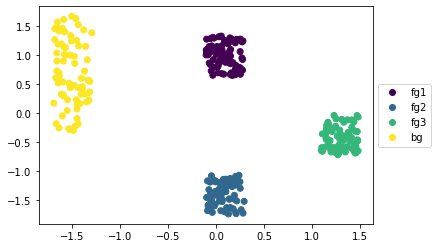

In [6]:
scatter = plt.scatter(x[:,0],x[:,1],c=y)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
           handles=scatter.legend_elements()[0],labels=("fg1","fg2","fg3","bg"))

In [7]:
desired_num = 1100
mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
m = 500
for j in tqdm(range(desired_num)):
    np.random.seed(j)
    fg_class  = np.random.randint(0,3)
    fg_idx = np.random.randint(0,m)
    a = []
    for i in range(m):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(3,4)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(np.reshape(a,(m,2)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

100%|██████████████████████████████████████| 1100/1100 [00:10<00:00, 106.61it/s]


In [8]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]



In [9]:
batch = 250
training_size = 100
msd1 = MosaicDataset(mosaic_list_of_images[0:training_size], mosaic_label[0:training_size] , fore_idx[0:training_size])
train_loader = DataLoader( msd1 ,batch_size= batch ,shuffle=True)

msd2 = MosaicDataset(mosaic_list_of_images[training_size:], mosaic_label[training_size:] , fore_idx[training_size:])
test_loader = DataLoader( msd2 ,batch_size= batch ,shuffle=True)

In [10]:
def my_cross_entropy(output,target,alpha,n_classes):
    if n_classes>2:
        criterion = nn.CrossEntropyLoss(reduce=False)
    else:
        criterion = nn.BCELoss(reduce=False)
    
    batch = output.size(0)
    patches = output.size(1)
    
    
    output = torch.reshape(output,(batch*patches,3))
    
    
    target = target.repeat_interleave(patches)
    
    loss = criterion(output,target)
    
    loss = torch.reshape(loss,(batch,patches))

    final_loss = torch.sum(torch.mul(loss,alpha),dim=1)

    final_loss = torch.mean(final_loss,dim=0)
    return final_loss

In [11]:
def save_analysis(trainloader,testloader,focus,classification,n_classes):
    focus.eval()
    classification.eval()
    fg_indexes = []
    alpha_argmax = []
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for data in trainloader:
            inputs, labels,foregrnd_index = data
            inputs = inputs.double()
            inputs = inputs.to(device)
            alphas,attnd_inputs= focus(inputs)
            outputs = classification(attnd_inputs)
            if n_classes > 2:
                _,predicted= torch.max(outputs,dim=1)
            else:
                predicted = (outputs.data[:,0]>0.5).type(torch.int64)
            
            true_labels.append(labels)
            predicted_labels.append(predicted.cpu().numpy())
            index = torch.argmax(alphas,dim=1)
            fg_indexes.append(foregrnd_index.numpy())
            alpha_argmax.append(index.cpu().numpy())
            #print(alphas[labels==0].shape,torch.max(alphas[labels==0],dim=1),"foreground",foregrnd_index[labels==0])
            #print(alphas[labels==1].shape,torch.max(alphas[labels==1],dim=1),"foreground",foregrnd_index[labels==1])
            #print(alphas[labels==2].shape,torch.max(alphas[labels==2],dim=1),"foreground",foregrnd_index[labels==2])
    fg_indexes = np.concatenate(fg_indexes,axis=0)
    alpha_argmax = np.concatenate(alpha_argmax,axis=0)
    true_labels = np.concatenate(true_labels,axis=0)
    predicted_labels = np.concatenate(predicted_labels,axis=0)

    
    ftpt = np.sum(np.logical_and(alpha_argmax == fg_indexes, predicted_labels == true_labels))
    ffpt = np.sum(np.logical_and(alpha_argmax != fg_indexes, predicted_labels == true_labels))
    ftpf = np.sum(np.logical_and(alpha_argmax == fg_indexes, predicted_labels != true_labels))
    ffpf = np.sum(np.logical_and(alpha_argmax != fg_indexes, predicted_labels != true_labels))
    trn_analysis = [ftpt,ffpt,ftpf,ffpf]
    
    fg_indexes = []
    alpha_argmax = []
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for data in testloader:
            inputs, labels,foregrnd_index = data
            inputs = inputs.double()
            inputs = inputs.to(device)
            alphas,attnd_inputs= focus(inputs)
            outputs = classification(attnd_inputs)
            if len(torch.unique(labels)) > 2:
                _,predicted= torch.max(outputs,dim=1)
            else:
                predicted = (outputs.data[:,0]>0.5).type(torch.int64)
                
            true_labels.append(labels)
            predicted_labels.append(predicted.cpu().numpy())
            index = torch.argmax(alphas,dim=1)
            fg_indexes.append(foregrnd_index.numpy())
            alpha_argmax.append(index.cpu().numpy())
    fg_indexes = np.concatenate(fg_indexes,axis=0)
    alpha_argmax = np.concatenate(alpha_argmax,axis=0)
    true_labels = np.concatenate(true_labels,axis=0)
    predicted_labels = np.concatenate(predicted_labels,axis=0)    
    ftpt = np.sum(np.logical_and(alpha_argmax == fg_indexes, predicted_labels == true_labels))
    ffpt = np.sum(np.logical_and(alpha_argmax != fg_indexes, predicted_labels == true_labels))
    ftpf = np.sum(np.logical_and(alpha_argmax == fg_indexes, predicted_labels != true_labels))
    ffpf = np.sum(np.logical_and(alpha_argmax != fg_indexes, predicted_labels != true_labels))
    tst_analysis = [ftpt,ffpt,ftpf,ffpf]
    
    
    return trn_analysis,tst_analysis

# soft attention

In [12]:
class Focus(nn.Module):
    def __init__(self,input_dims,attention,bias_=False,bn_=False):
        super(Focus, self).__init__()
        self.input_dims = input_dims 
        self.attention = attention
        self.bias_ = bias_
        self.fc1 = nn.Linear(self.input_dims,1, bias=self.bias_)
        self.bn_ = bn_
        if self.bn_:
            self.bn = nn.BatchNorm1d(input_dims)
        
    def forward_soft_Attention(self,z):
        batch = z.size(0)
        patches = z.size(1)
        z = z.view(batch,patches,self.input_dims)
        alp1,ft1 = self.helper(z)
        alpha = F.softmax(alp1,dim=1)
        y = torch.sum(alpha*ft1,dim=1)
        
        if self.bn_:
            y = self.bn(y)
        
        alpha =alpha[:,:,0]
        return alpha,y   # return  alpha values,attended data
    def forward_hard_Attention(self,z):
        batch = z.size(0)
        patches = z.size(1)
        z = z.view(batch,patches,2*1)
        alp1,ft1 = self.helper(z)

        alpha = F.softmax(alp1,dim=1)
        
        if self.training:
            alpha =alpha[:,:,0]
            y = ft1 
            return alpha,y
        else:
            index = torch.argmax(alpha,dim=1)
            #print(index)
            hard_alpha = torch.nn.functional.one_hot(index[:,0], patches)
            y = torch.sum(hard_alpha[:,:,None]*ft1,dim=1)
            alpha = alpha[:,:,0]
            return alpha,y
        
    def forward(self,z): 
        if self.attention == "hard":
            alpha,y = self.forward_hard_Attention(z)
            return alpha,y
        elif self.attention == "soft":
            alpha,y = self.forward_soft_Attention(z)
            return alpha,y
        else:
            print("not correct Attention type")
            return None

    def helper(self, x):
        x1 = x
        x = self.fc1(x)
        return x,x1

In [13]:
class Classification(nn.Module):
    def __init__(self,input_dims,output_dims):
        super(Classification, self).__init__()
        self.input_dims = input_dims
        self.output_dims = output_dims 
        self.fc1 = nn.Linear(self.input_dims, self.output_dims)
    def forward(self, x):
        x = self.fc1(x)
        if self.output_dims ==1:
            x = torch.sigmoid(x)
        return x

In [14]:
def initialize_zeros_weights(m):
    if isinstance(m,nn.Linear):
        nn.init.zeros_(m.weight.data)
        if m.bias is not None:
            nn.init.zeros_(m.bias.data)

In [15]:
def train_attention_models(trainloader,focus_module,classification_module,
                           n_classes,nos_epochs,attention,learning_rate=0.01):
    
    
    if n_classes > 2:
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.BCELoss()
    optimizer_classify = optim.SGD(classification_module.parameters(), lr=learning_rate)#,  momentum=0.09)
    optimizer_focus = optim.SGD(focus_module.parameters(), lr=learning_rate)# , momentum=0.09)
    loss_list=[]
    for epoch in range(nos_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_loss = []
        focus_module.train()
        classification_module.train()
        for i, data in  enumerate(trainloader):
            inputs , labels , fore_idx = data
            batch = inputs.size(0)
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.double()
            # zero the parameter gradients
            optimizer_focus.zero_grad()
            optimizer_classify.zero_grad()
            alphas, avg_images = focus_module(inputs)
            outputs = classification_module(avg_images)
            #print(outputs.shape)
            
            # predicted values
            if n_classes > 2:
                _,predicted= torch.max(outputs,dim=1)
            else:
                predicted = (outputs.data[:,0]>0.5).type(torch.int64)
            
            # calculate loss
            if attention == "soft":
                loss = criterion(outputs,labels)
            if attention == "hard":
                loss = my_cross_entropy(outputs,labels,alphas,n_classes)
            loss.backward()
            optimizer_focus.step()
            optimizer_classify.step()
            epoch_loss.append(loss.item())
        print('[%d] loss: %.3f' %(epoch + 1, np.mean(epoch_loss)))
        loss_list.append(np.mean(epoch_loss))
        if(np.mean(epoch_loss) <= 0.01):
            break
    print('Finished Training')
    return focus_module,classification_module,loss_list 


In [16]:
focus_net = Focus(input_dims = 2,attention="soft",bias_=False,bn_=False).double()
focus_net = focus_net.to(device)

classify = Classification(input_dims=2,output_dims=3).double()
classify = classify.to(device)

focus_net.apply(initialize_zeros_weights)
classify.apply(initialize_zeros_weights)
# parameters
for params in focus_net.parameters():
    print(params)
for params in classify.parameters():
    print(params)

Parameter containing:
tensor([[0., 0.]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([0., 0., 0.], dtype=torch.float64, requires_grad=True)


In [17]:
save_analysis(train_loader,test_loader,focus_net,classify,3) # ftpt ffpt ftpf ffpf

([0, 26, 0, 74], [0, 323, 1, 676])

In [18]:
focus_net,classify,loss_list = train_attention_models(train_loader,focus_net,classify,
                           learning_rate=0.5,n_classes=3,nos_epochs=10000,attention="soft")

[1] loss: 1.099
[2] loss: 1.087
[3] loss: 1.085
[4] loss: 1.085
[5] loss: 1.085
[6] loss: 1.085
[7] loss: 1.085
[8] loss: 1.085
[9] loss: 1.085
[10] loss: 1.085
[11] loss: 1.085
[12] loss: 1.085
[13] loss: 1.085
[14] loss: 1.085
[15] loss: 1.085
[16] loss: 1.085
[17] loss: 1.085
[18] loss: 1.085
[19] loss: 1.085
[20] loss: 1.085
[21] loss: 1.085
[22] loss: 1.085
[23] loss: 1.085
[24] loss: 1.085
[25] loss: 1.085
[26] loss: 1.085
[27] loss: 1.085
[28] loss: 1.085
[29] loss: 1.085
[30] loss: 1.085
[31] loss: 1.085
[32] loss: 1.085
[33] loss: 1.085
[34] loss: 1.085
[35] loss: 1.085
[36] loss: 1.085
[37] loss: 1.085
[38] loss: 1.085
[39] loss: 1.085
[40] loss: 1.085
[41] loss: 1.085
[42] loss: 1.085
[43] loss: 1.085
[44] loss: 1.085
[45] loss: 1.085
[46] loss: 1.085
[47] loss: 1.085
[48] loss: 1.085
[49] loss: 1.085
[50] loss: 1.085
[51] loss: 1.085
[52] loss: 1.085
[53] loss: 1.085
[54] loss: 1.085
[55] loss: 1.085
[56] loss: 1.085
[57] loss: 1.085
[58] loss: 1.085
[59] loss: 1.085
[60] l

[502] loss: 1.083
[503] loss: 1.083
[504] loss: 1.083
[505] loss: 1.083
[506] loss: 1.083
[507] loss: 1.083
[508] loss: 1.083
[509] loss: 1.083
[510] loss: 1.083
[511] loss: 1.083
[512] loss: 1.083
[513] loss: 1.083
[514] loss: 1.083
[515] loss: 1.083
[516] loss: 1.083
[517] loss: 1.083
[518] loss: 1.083
[519] loss: 1.083
[520] loss: 1.083
[521] loss: 1.083
[522] loss: 1.083
[523] loss: 1.083
[524] loss: 1.083
[525] loss: 1.083
[526] loss: 1.083
[527] loss: 1.083
[528] loss: 1.083
[529] loss: 1.083
[530] loss: 1.083
[531] loss: 1.083
[532] loss: 1.083
[533] loss: 1.083
[534] loss: 1.083
[535] loss: 1.083
[536] loss: 1.083
[537] loss: 1.083
[538] loss: 1.083
[539] loss: 1.083
[540] loss: 1.083
[541] loss: 1.083
[542] loss: 1.083
[543] loss: 1.083
[544] loss: 1.083
[545] loss: 1.083
[546] loss: 1.083
[547] loss: 1.083
[548] loss: 1.083
[549] loss: 1.083
[550] loss: 1.083
[551] loss: 1.083
[552] loss: 1.083
[553] loss: 1.083
[554] loss: 1.083
[555] loss: 1.083
[556] loss: 1.083
[557] loss

[965] loss: 1.082
[966] loss: 1.082
[967] loss: 1.082
[968] loss: 1.082
[969] loss: 1.082
[970] loss: 1.082
[971] loss: 1.082
[972] loss: 1.082
[973] loss: 1.082
[974] loss: 1.082
[975] loss: 1.082
[976] loss: 1.082
[977] loss: 1.082
[978] loss: 1.082
[979] loss: 1.082
[980] loss: 1.082
[981] loss: 1.082
[982] loss: 1.082
[983] loss: 1.082
[984] loss: 1.082
[985] loss: 1.082
[986] loss: 1.082
[987] loss: 1.082
[988] loss: 1.082
[989] loss: 1.082
[990] loss: 1.082
[991] loss: 1.082
[992] loss: 1.082
[993] loss: 1.082
[994] loss: 1.082
[995] loss: 1.082
[996] loss: 1.082
[997] loss: 1.082
[998] loss: 1.082
[999] loss: 1.082
[1000] loss: 1.082
[1001] loss: 1.082
[1002] loss: 1.082
[1003] loss: 1.082
[1004] loss: 1.082
[1005] loss: 1.082
[1006] loss: 1.082
[1007] loss: 1.082
[1008] loss: 1.082
[1009] loss: 1.082
[1010] loss: 1.082
[1011] loss: 1.082
[1012] loss: 1.082
[1013] loss: 1.082
[1014] loss: 1.082
[1015] loss: 1.082
[1016] loss: 1.082
[1017] loss: 1.082
[1018] loss: 1.082
[1019] lo

[1407] loss: 1.080
[1408] loss: 1.080
[1409] loss: 1.080
[1410] loss: 1.080
[1411] loss: 1.080
[1412] loss: 1.080
[1413] loss: 1.080
[1414] loss: 1.080
[1415] loss: 1.080
[1416] loss: 1.080
[1417] loss: 1.080
[1418] loss: 1.080
[1419] loss: 1.080
[1420] loss: 1.080
[1421] loss: 1.080
[1422] loss: 1.080
[1423] loss: 1.080
[1424] loss: 1.080
[1425] loss: 1.080
[1426] loss: 1.080
[1427] loss: 1.080
[1428] loss: 1.080
[1429] loss: 1.080
[1430] loss: 1.080
[1431] loss: 1.080
[1432] loss: 1.080
[1433] loss: 1.080
[1434] loss: 1.080
[1435] loss: 1.080
[1436] loss: 1.080
[1437] loss: 1.080
[1438] loss: 1.080
[1439] loss: 1.080
[1440] loss: 1.080
[1441] loss: 1.080
[1442] loss: 1.080
[1443] loss: 1.080
[1444] loss: 1.080
[1445] loss: 1.080
[1446] loss: 1.080
[1447] loss: 1.080
[1448] loss: 1.080
[1449] loss: 1.080
[1450] loss: 1.080
[1451] loss: 1.080
[1452] loss: 1.080
[1453] loss: 1.080
[1454] loss: 1.080
[1455] loss: 1.080
[1456] loss: 1.080
[1457] loss: 1.080
[1458] loss: 1.080
[1459] loss:

[1860] loss: 1.078
[1861] loss: 1.078
[1862] loss: 1.078
[1863] loss: 1.078
[1864] loss: 1.078
[1865] loss: 1.078
[1866] loss: 1.078
[1867] loss: 1.078
[1868] loss: 1.078
[1869] loss: 1.078
[1870] loss: 1.078
[1871] loss: 1.078
[1872] loss: 1.078
[1873] loss: 1.078
[1874] loss: 1.078
[1875] loss: 1.078
[1876] loss: 1.078
[1877] loss: 1.078
[1878] loss: 1.078
[1879] loss: 1.078
[1880] loss: 1.078
[1881] loss: 1.078
[1882] loss: 1.078
[1883] loss: 1.078
[1884] loss: 1.078
[1885] loss: 1.078
[1886] loss: 1.078
[1887] loss: 1.078
[1888] loss: 1.078
[1889] loss: 1.078
[1890] loss: 1.078
[1891] loss: 1.078
[1892] loss: 1.078
[1893] loss: 1.078
[1894] loss: 1.078
[1895] loss: 1.078
[1896] loss: 1.078
[1897] loss: 1.078
[1898] loss: 1.078
[1899] loss: 1.078
[1900] loss: 1.078
[1901] loss: 1.078
[1902] loss: 1.078
[1903] loss: 1.078
[1904] loss: 1.078
[1905] loss: 1.078
[1906] loss: 1.078
[1907] loss: 1.078
[1908] loss: 1.078
[1909] loss: 1.078
[1910] loss: 1.078
[1911] loss: 1.078
[1912] loss:

[2316] loss: 1.077
[2317] loss: 1.077
[2318] loss: 1.077
[2319] loss: 1.077
[2320] loss: 1.077
[2321] loss: 1.077
[2322] loss: 1.077
[2323] loss: 1.077
[2324] loss: 1.077
[2325] loss: 1.077
[2326] loss: 1.077
[2327] loss: 1.077
[2328] loss: 1.077
[2329] loss: 1.077
[2330] loss: 1.077
[2331] loss: 1.077
[2332] loss: 1.077
[2333] loss: 1.077
[2334] loss: 1.077
[2335] loss: 1.077
[2336] loss: 1.077
[2337] loss: 1.077
[2338] loss: 1.077
[2339] loss: 1.077
[2340] loss: 1.077
[2341] loss: 1.077
[2342] loss: 1.077
[2343] loss: 1.077
[2344] loss: 1.077
[2345] loss: 1.077
[2346] loss: 1.077
[2347] loss: 1.077
[2348] loss: 1.077
[2349] loss: 1.077
[2350] loss: 1.077
[2351] loss: 1.077
[2352] loss: 1.077
[2353] loss: 1.077
[2354] loss: 1.077
[2355] loss: 1.077
[2356] loss: 1.077
[2357] loss: 1.077
[2358] loss: 1.077
[2359] loss: 1.077
[2360] loss: 1.077
[2361] loss: 1.077
[2362] loss: 1.077
[2363] loss: 1.077
[2364] loss: 1.077
[2365] loss: 1.076
[2366] loss: 1.076
[2367] loss: 1.076
[2368] loss:

[2818] loss: 1.075
[2819] loss: 1.075
[2820] loss: 1.075
[2821] loss: 1.075
[2822] loss: 1.075
[2823] loss: 1.075
[2824] loss: 1.075
[2825] loss: 1.075
[2826] loss: 1.075
[2827] loss: 1.075
[2828] loss: 1.075
[2829] loss: 1.075
[2830] loss: 1.075
[2831] loss: 1.075
[2832] loss: 1.075
[2833] loss: 1.075
[2834] loss: 1.075
[2835] loss: 1.075
[2836] loss: 1.075
[2837] loss: 1.075
[2838] loss: 1.075
[2839] loss: 1.075
[2840] loss: 1.075
[2841] loss: 1.075
[2842] loss: 1.075
[2843] loss: 1.075
[2844] loss: 1.075
[2845] loss: 1.075
[2846] loss: 1.075
[2847] loss: 1.075
[2848] loss: 1.075
[2849] loss: 1.075
[2850] loss: 1.075
[2851] loss: 1.075
[2852] loss: 1.075
[2853] loss: 1.075
[2854] loss: 1.075
[2855] loss: 1.075
[2856] loss: 1.075
[2857] loss: 1.075
[2858] loss: 1.075
[2859] loss: 1.075
[2860] loss: 1.075
[2861] loss: 1.075
[2862] loss: 1.075
[2863] loss: 1.075
[2864] loss: 1.075
[2865] loss: 1.075
[2866] loss: 1.075
[2867] loss: 1.075
[2868] loss: 1.075
[2869] loss: 1.075
[2870] loss:

[3318] loss: 1.073
[3319] loss: 1.073
[3320] loss: 1.073
[3321] loss: 1.073
[3322] loss: 1.073
[3323] loss: 1.073
[3324] loss: 1.073
[3325] loss: 1.073
[3326] loss: 1.073
[3327] loss: 1.073
[3328] loss: 1.073
[3329] loss: 1.073
[3330] loss: 1.073
[3331] loss: 1.073
[3332] loss: 1.073
[3333] loss: 1.073
[3334] loss: 1.073
[3335] loss: 1.073
[3336] loss: 1.073
[3337] loss: 1.073
[3338] loss: 1.073
[3339] loss: 1.073
[3340] loss: 1.073
[3341] loss: 1.073
[3342] loss: 1.073
[3343] loss: 1.073
[3344] loss: 1.073
[3345] loss: 1.073
[3346] loss: 1.073
[3347] loss: 1.073
[3348] loss: 1.073
[3349] loss: 1.073
[3350] loss: 1.073
[3351] loss: 1.073
[3352] loss: 1.073
[3353] loss: 1.073
[3354] loss: 1.073
[3355] loss: 1.073
[3356] loss: 1.073
[3357] loss: 1.073
[3358] loss: 1.073
[3359] loss: 1.073
[3360] loss: 1.073
[3361] loss: 1.073
[3362] loss: 1.073
[3363] loss: 1.073
[3364] loss: 1.073
[3365] loss: 1.073
[3366] loss: 1.073
[3367] loss: 1.073
[3368] loss: 1.073
[3369] loss: 1.073
[3370] loss:

[3750] loss: 1.072
[3751] loss: 1.072
[3752] loss: 1.072
[3753] loss: 1.072
[3754] loss: 1.072
[3755] loss: 1.072
[3756] loss: 1.072
[3757] loss: 1.072
[3758] loss: 1.072
[3759] loss: 1.072
[3760] loss: 1.072
[3761] loss: 1.072
[3762] loss: 1.072
[3763] loss: 1.072
[3764] loss: 1.072
[3765] loss: 1.072
[3766] loss: 1.072
[3767] loss: 1.072
[3768] loss: 1.072
[3769] loss: 1.072
[3770] loss: 1.072
[3771] loss: 1.072
[3772] loss: 1.072
[3773] loss: 1.072
[3774] loss: 1.072
[3775] loss: 1.072
[3776] loss: 1.072
[3777] loss: 1.072
[3778] loss: 1.072
[3779] loss: 1.072
[3780] loss: 1.072
[3781] loss: 1.072
[3782] loss: 1.072
[3783] loss: 1.072
[3784] loss: 1.072
[3785] loss: 1.072
[3786] loss: 1.072
[3787] loss: 1.072
[3788] loss: 1.072
[3789] loss: 1.072
[3790] loss: 1.072
[3791] loss: 1.072
[3792] loss: 1.072
[3793] loss: 1.072
[3794] loss: 1.072
[3795] loss: 1.072
[3796] loss: 1.072
[3797] loss: 1.072
[3798] loss: 1.072
[3799] loss: 1.072
[3800] loss: 1.072
[3801] loss: 1.072
[3802] loss:

[4199] loss: 1.070
[4200] loss: 1.070
[4201] loss: 1.070
[4202] loss: 1.070
[4203] loss: 1.070
[4204] loss: 1.070
[4205] loss: 1.070
[4206] loss: 1.070
[4207] loss: 1.070
[4208] loss: 1.070
[4209] loss: 1.070
[4210] loss: 1.070
[4211] loss: 1.070
[4212] loss: 1.070
[4213] loss: 1.070
[4214] loss: 1.070
[4215] loss: 1.070
[4216] loss: 1.070
[4217] loss: 1.070
[4218] loss: 1.070
[4219] loss: 1.070
[4220] loss: 1.070
[4221] loss: 1.070
[4222] loss: 1.070
[4223] loss: 1.070
[4224] loss: 1.070
[4225] loss: 1.070
[4226] loss: 1.070
[4227] loss: 1.070
[4228] loss: 1.070
[4229] loss: 1.070
[4230] loss: 1.070
[4231] loss: 1.070
[4232] loss: 1.070
[4233] loss: 1.070
[4234] loss: 1.070
[4235] loss: 1.070
[4236] loss: 1.070
[4237] loss: 1.070
[4238] loss: 1.070
[4239] loss: 1.070
[4240] loss: 1.070
[4241] loss: 1.070
[4242] loss: 1.070
[4243] loss: 1.070
[4244] loss: 1.070
[4245] loss: 1.070
[4246] loss: 1.070
[4247] loss: 1.070
[4248] loss: 1.070
[4249] loss: 1.070
[4250] loss: 1.070
[4251] loss:

[4633] loss: 1.069
[4634] loss: 1.069
[4635] loss: 1.069
[4636] loss: 1.069
[4637] loss: 1.069
[4638] loss: 1.069
[4639] loss: 1.069
[4640] loss: 1.069
[4641] loss: 1.069
[4642] loss: 1.069
[4643] loss: 1.069
[4644] loss: 1.069
[4645] loss: 1.069
[4646] loss: 1.069
[4647] loss: 1.069
[4648] loss: 1.069
[4649] loss: 1.069
[4650] loss: 1.069
[4651] loss: 1.069
[4652] loss: 1.069
[4653] loss: 1.069
[4654] loss: 1.069
[4655] loss: 1.069
[4656] loss: 1.069
[4657] loss: 1.069
[4658] loss: 1.069
[4659] loss: 1.069
[4660] loss: 1.069
[4661] loss: 1.069
[4662] loss: 1.069
[4663] loss: 1.069
[4664] loss: 1.069
[4665] loss: 1.069
[4666] loss: 1.069
[4667] loss: 1.069
[4668] loss: 1.069
[4669] loss: 1.069
[4670] loss: 1.069
[4671] loss: 1.069
[4672] loss: 1.069
[4673] loss: 1.069
[4674] loss: 1.069
[4675] loss: 1.069
[4676] loss: 1.069
[4677] loss: 1.069
[4678] loss: 1.069
[4679] loss: 1.069
[4680] loss: 1.069
[4681] loss: 1.069
[4682] loss: 1.069
[4683] loss: 1.069
[4684] loss: 1.069
[4685] loss:

[5084] loss: 1.068
[5085] loss: 1.068
[5086] loss: 1.068
[5087] loss: 1.068
[5088] loss: 1.068
[5089] loss: 1.068
[5090] loss: 1.068
[5091] loss: 1.068
[5092] loss: 1.068
[5093] loss: 1.068
[5094] loss: 1.068
[5095] loss: 1.068
[5096] loss: 1.068
[5097] loss: 1.068
[5098] loss: 1.068
[5099] loss: 1.068
[5100] loss: 1.068
[5101] loss: 1.068
[5102] loss: 1.068
[5103] loss: 1.068
[5104] loss: 1.068
[5105] loss: 1.068
[5106] loss: 1.068
[5107] loss: 1.068
[5108] loss: 1.068
[5109] loss: 1.068
[5110] loss: 1.068
[5111] loss: 1.068
[5112] loss: 1.068
[5113] loss: 1.068
[5114] loss: 1.068
[5115] loss: 1.068
[5116] loss: 1.068
[5117] loss: 1.068
[5118] loss: 1.068
[5119] loss: 1.068
[5120] loss: 1.068
[5121] loss: 1.068
[5122] loss: 1.068
[5123] loss: 1.068
[5124] loss: 1.068
[5125] loss: 1.068
[5126] loss: 1.068
[5127] loss: 1.068
[5128] loss: 1.068
[5129] loss: 1.068
[5130] loss: 1.068
[5131] loss: 1.068
[5132] loss: 1.068
[5133] loss: 1.068
[5134] loss: 1.068
[5135] loss: 1.068
[5136] loss:

[5553] loss: 1.067
[5554] loss: 1.067
[5555] loss: 1.067
[5556] loss: 1.067
[5557] loss: 1.067
[5558] loss: 1.067
[5559] loss: 1.067
[5560] loss: 1.067
[5561] loss: 1.067
[5562] loss: 1.067
[5563] loss: 1.067
[5564] loss: 1.067
[5565] loss: 1.067
[5566] loss: 1.067
[5567] loss: 1.067
[5568] loss: 1.067
[5569] loss: 1.067
[5570] loss: 1.067
[5571] loss: 1.067
[5572] loss: 1.067
[5573] loss: 1.067
[5574] loss: 1.067
[5575] loss: 1.067
[5576] loss: 1.067
[5577] loss: 1.067
[5578] loss: 1.067
[5579] loss: 1.067
[5580] loss: 1.067
[5581] loss: 1.067
[5582] loss: 1.067
[5583] loss: 1.066
[5584] loss: 1.066
[5585] loss: 1.066
[5586] loss: 1.066
[5587] loss: 1.066
[5588] loss: 1.066
[5589] loss: 1.066
[5590] loss: 1.066
[5591] loss: 1.066
[5592] loss: 1.066
[5593] loss: 1.066
[5594] loss: 1.066
[5595] loss: 1.066
[5596] loss: 1.066
[5597] loss: 1.066
[5598] loss: 1.066
[5599] loss: 1.066
[5600] loss: 1.066
[5601] loss: 1.066
[5602] loss: 1.066
[5603] loss: 1.066
[5604] loss: 1.066
[5605] loss:

[6011] loss: 1.065
[6012] loss: 1.065
[6013] loss: 1.065
[6014] loss: 1.065
[6015] loss: 1.065
[6016] loss: 1.065
[6017] loss: 1.065
[6018] loss: 1.065
[6019] loss: 1.065
[6020] loss: 1.065
[6021] loss: 1.065
[6022] loss: 1.065
[6023] loss: 1.065
[6024] loss: 1.065
[6025] loss: 1.065
[6026] loss: 1.065
[6027] loss: 1.065
[6028] loss: 1.065
[6029] loss: 1.065
[6030] loss: 1.065
[6031] loss: 1.065
[6032] loss: 1.065
[6033] loss: 1.065
[6034] loss: 1.065
[6035] loss: 1.065
[6036] loss: 1.065
[6037] loss: 1.065
[6038] loss: 1.065
[6039] loss: 1.065
[6040] loss: 1.065
[6041] loss: 1.065
[6042] loss: 1.065
[6043] loss: 1.065
[6044] loss: 1.065
[6045] loss: 1.065
[6046] loss: 1.065
[6047] loss: 1.065
[6048] loss: 1.065
[6049] loss: 1.065
[6050] loss: 1.065
[6051] loss: 1.065
[6052] loss: 1.065
[6053] loss: 1.065
[6054] loss: 1.065
[6055] loss: 1.065
[6056] loss: 1.065
[6057] loss: 1.065
[6058] loss: 1.065
[6059] loss: 1.065
[6060] loss: 1.065
[6061] loss: 1.065
[6062] loss: 1.065
[6063] loss:

[6453] loss: 1.064
[6454] loss: 1.064
[6455] loss: 1.064
[6456] loss: 1.064
[6457] loss: 1.064
[6458] loss: 1.064
[6459] loss: 1.064
[6460] loss: 1.064
[6461] loss: 1.064
[6462] loss: 1.064
[6463] loss: 1.064
[6464] loss: 1.064
[6465] loss: 1.064
[6466] loss: 1.064
[6467] loss: 1.064
[6468] loss: 1.064
[6469] loss: 1.064
[6470] loss: 1.064
[6471] loss: 1.064
[6472] loss: 1.064
[6473] loss: 1.064
[6474] loss: 1.064
[6475] loss: 1.064
[6476] loss: 1.064
[6477] loss: 1.064
[6478] loss: 1.064
[6479] loss: 1.064
[6480] loss: 1.064
[6481] loss: 1.064
[6482] loss: 1.064
[6483] loss: 1.064
[6484] loss: 1.064
[6485] loss: 1.064
[6486] loss: 1.064
[6487] loss: 1.064
[6488] loss: 1.064
[6489] loss: 1.064
[6490] loss: 1.064
[6491] loss: 1.064
[6492] loss: 1.064
[6493] loss: 1.064
[6494] loss: 1.064
[6495] loss: 1.064
[6496] loss: 1.064
[6497] loss: 1.064
[6498] loss: 1.064
[6499] loss: 1.064
[6500] loss: 1.064
[6501] loss: 1.064
[6502] loss: 1.064
[6503] loss: 1.064
[6504] loss: 1.064
[6505] loss:

[6885] loss: 1.064
[6886] loss: 1.064
[6887] loss: 1.064
[6888] loss: 1.064
[6889] loss: 1.064
[6890] loss: 1.064
[6891] loss: 1.063
[6892] loss: 1.063
[6893] loss: 1.063
[6894] loss: 1.063
[6895] loss: 1.063
[6896] loss: 1.063
[6897] loss: 1.063
[6898] loss: 1.063
[6899] loss: 1.063
[6900] loss: 1.063
[6901] loss: 1.063
[6902] loss: 1.063
[6903] loss: 1.063
[6904] loss: 1.063
[6905] loss: 1.063
[6906] loss: 1.063
[6907] loss: 1.063
[6908] loss: 1.063
[6909] loss: 1.063
[6910] loss: 1.063
[6911] loss: 1.063
[6912] loss: 1.063
[6913] loss: 1.063
[6914] loss: 1.063
[6915] loss: 1.063
[6916] loss: 1.063
[6917] loss: 1.063
[6918] loss: 1.063
[6919] loss: 1.063
[6920] loss: 1.063
[6921] loss: 1.063
[6922] loss: 1.063
[6923] loss: 1.063
[6924] loss: 1.063
[6925] loss: 1.063
[6926] loss: 1.063
[6927] loss: 1.063
[6928] loss: 1.063
[6929] loss: 1.063
[6930] loss: 1.063
[6931] loss: 1.063
[6932] loss: 1.063
[6933] loss: 1.063
[6934] loss: 1.063
[6935] loss: 1.063
[6936] loss: 1.063
[6937] loss:

[7319] loss: 1.063
[7320] loss: 1.063
[7321] loss: 1.063
[7322] loss: 1.063
[7323] loss: 1.063
[7324] loss: 1.063
[7325] loss: 1.063
[7326] loss: 1.063
[7327] loss: 1.063
[7328] loss: 1.063
[7329] loss: 1.063
[7330] loss: 1.063
[7331] loss: 1.063
[7332] loss: 1.063
[7333] loss: 1.063
[7334] loss: 1.063
[7335] loss: 1.063
[7336] loss: 1.063
[7337] loss: 1.063
[7338] loss: 1.063
[7339] loss: 1.063
[7340] loss: 1.063
[7341] loss: 1.063
[7342] loss: 1.063
[7343] loss: 1.063
[7344] loss: 1.063
[7345] loss: 1.063
[7346] loss: 1.063
[7347] loss: 1.063
[7348] loss: 1.063
[7349] loss: 1.063
[7350] loss: 1.063
[7351] loss: 1.063
[7352] loss: 1.063
[7353] loss: 1.063
[7354] loss: 1.063
[7355] loss: 1.063
[7356] loss: 1.063
[7357] loss: 1.063
[7358] loss: 1.063
[7359] loss: 1.063
[7360] loss: 1.063
[7361] loss: 1.063
[7362] loss: 1.063
[7363] loss: 1.063
[7364] loss: 1.063
[7365] loss: 1.063
[7366] loss: 1.063
[7367] loss: 1.063
[7368] loss: 1.063
[7369] loss: 1.063
[7370] loss: 1.063
[7371] loss:

[7758] loss: 1.062
[7759] loss: 1.062
[7760] loss: 1.062
[7761] loss: 1.062
[7762] loss: 1.062
[7763] loss: 1.062
[7764] loss: 1.062
[7765] loss: 1.062
[7766] loss: 1.062
[7767] loss: 1.062
[7768] loss: 1.062
[7769] loss: 1.062
[7770] loss: 1.062
[7771] loss: 1.062
[7772] loss: 1.062
[7773] loss: 1.062
[7774] loss: 1.062
[7775] loss: 1.062
[7776] loss: 1.062
[7777] loss: 1.062
[7778] loss: 1.062
[7779] loss: 1.062
[7780] loss: 1.062
[7781] loss: 1.062
[7782] loss: 1.062
[7783] loss: 1.062
[7784] loss: 1.062
[7785] loss: 1.062
[7786] loss: 1.062
[7787] loss: 1.062
[7788] loss: 1.062
[7789] loss: 1.062
[7790] loss: 1.062
[7791] loss: 1.062
[7792] loss: 1.062
[7793] loss: 1.062
[7794] loss: 1.062
[7795] loss: 1.062
[7796] loss: 1.062
[7797] loss: 1.062
[7798] loss: 1.062
[7799] loss: 1.062
[7800] loss: 1.062
[7801] loss: 1.062
[7802] loss: 1.062
[7803] loss: 1.062
[7804] loss: 1.062
[7805] loss: 1.062
[7806] loss: 1.062
[7807] loss: 1.062
[7808] loss: 1.062
[7809] loss: 1.062
[7810] loss:

[8204] loss: 1.061
[8205] loss: 1.061
[8206] loss: 1.061
[8207] loss: 1.061
[8208] loss: 1.061
[8209] loss: 1.061
[8210] loss: 1.061
[8211] loss: 1.061
[8212] loss: 1.061
[8213] loss: 1.061
[8214] loss: 1.061
[8215] loss: 1.061
[8216] loss: 1.061
[8217] loss: 1.061
[8218] loss: 1.061
[8219] loss: 1.061
[8220] loss: 1.061
[8221] loss: 1.061
[8222] loss: 1.061
[8223] loss: 1.061
[8224] loss: 1.061
[8225] loss: 1.061
[8226] loss: 1.061
[8227] loss: 1.061
[8228] loss: 1.061
[8229] loss: 1.061
[8230] loss: 1.061
[8231] loss: 1.061
[8232] loss: 1.061
[8233] loss: 1.061
[8234] loss: 1.061
[8235] loss: 1.061
[8236] loss: 1.061
[8237] loss: 1.061
[8238] loss: 1.061
[8239] loss: 1.061
[8240] loss: 1.061
[8241] loss: 1.061
[8242] loss: 1.061
[8243] loss: 1.061
[8244] loss: 1.061
[8245] loss: 1.061
[8246] loss: 1.061
[8247] loss: 1.061
[8248] loss: 1.061
[8249] loss: 1.061
[8250] loss: 1.061
[8251] loss: 1.061
[8252] loss: 1.061
[8253] loss: 1.061
[8254] loss: 1.061
[8255] loss: 1.061
[8256] loss:

[8640] loss: 1.060
[8641] loss: 1.060
[8642] loss: 1.060
[8643] loss: 1.060
[8644] loss: 1.060
[8645] loss: 1.060
[8646] loss: 1.060
[8647] loss: 1.060
[8648] loss: 1.060
[8649] loss: 1.060
[8650] loss: 1.060
[8651] loss: 1.060
[8652] loss: 1.060
[8653] loss: 1.060
[8654] loss: 1.060
[8655] loss: 1.060
[8656] loss: 1.060
[8657] loss: 1.060
[8658] loss: 1.060
[8659] loss: 1.060
[8660] loss: 1.060
[8661] loss: 1.060
[8662] loss: 1.060
[8663] loss: 1.060
[8664] loss: 1.060
[8665] loss: 1.060
[8666] loss: 1.060
[8667] loss: 1.060
[8668] loss: 1.060
[8669] loss: 1.060
[8670] loss: 1.060
[8671] loss: 1.060
[8672] loss: 1.060
[8673] loss: 1.060
[8674] loss: 1.060
[8675] loss: 1.060
[8676] loss: 1.060
[8677] loss: 1.060
[8678] loss: 1.060
[8679] loss: 1.060
[8680] loss: 1.060
[8681] loss: 1.060
[8682] loss: 1.060
[8683] loss: 1.060
[8684] loss: 1.060
[8685] loss: 1.060
[8686] loss: 1.060
[8687] loss: 1.060
[8688] loss: 1.060
[8689] loss: 1.060
[8690] loss: 1.060
[8691] loss: 1.060
[8692] loss:

[9120] loss: 1.059
[9121] loss: 1.059
[9122] loss: 1.059
[9123] loss: 1.059
[9124] loss: 1.059
[9125] loss: 1.059
[9126] loss: 1.059
[9127] loss: 1.059
[9128] loss: 1.059
[9129] loss: 1.059
[9130] loss: 1.059
[9131] loss: 1.059
[9132] loss: 1.059
[9133] loss: 1.059
[9134] loss: 1.059
[9135] loss: 1.059
[9136] loss: 1.059
[9137] loss: 1.059
[9138] loss: 1.059
[9139] loss: 1.059
[9140] loss: 1.059
[9141] loss: 1.059
[9142] loss: 1.059
[9143] loss: 1.059
[9144] loss: 1.059
[9145] loss: 1.059
[9146] loss: 1.059
[9147] loss: 1.059
[9148] loss: 1.059
[9149] loss: 1.059
[9150] loss: 1.059
[9151] loss: 1.059
[9152] loss: 1.059
[9153] loss: 1.059
[9154] loss: 1.059
[9155] loss: 1.059
[9156] loss: 1.059
[9157] loss: 1.059
[9158] loss: 1.059
[9159] loss: 1.059
[9160] loss: 1.059
[9161] loss: 1.059
[9162] loss: 1.059
[9163] loss: 1.059
[9164] loss: 1.059
[9165] loss: 1.059
[9166] loss: 1.059
[9167] loss: 1.059
[9168] loss: 1.059
[9169] loss: 1.059
[9170] loss: 1.059
[9171] loss: 1.059
[9172] loss:

[9557] loss: 1.066
[9558] loss: 1.066
[9559] loss: 1.066
[9560] loss: 1.066
[9561] loss: 1.066
[9562] loss: 1.066
[9563] loss: 1.066
[9564] loss: 1.066
[9565] loss: 1.066
[9566] loss: 1.066
[9567] loss: 1.067
[9568] loss: 1.066
[9569] loss: 1.067
[9570] loss: 1.066
[9571] loss: 1.067
[9572] loss: 1.066
[9573] loss: 1.067
[9574] loss: 1.066
[9575] loss: 1.067
[9576] loss: 1.066
[9577] loss: 1.067
[9578] loss: 1.066
[9579] loss: 1.067
[9580] loss: 1.066
[9581] loss: 1.067
[9582] loss: 1.066
[9583] loss: 1.067
[9584] loss: 1.066
[9585] loss: 1.067
[9586] loss: 1.066
[9587] loss: 1.067
[9588] loss: 1.066
[9589] loss: 1.067
[9590] loss: 1.066
[9591] loss: 1.067
[9592] loss: 1.067
[9593] loss: 1.067
[9594] loss: 1.067
[9595] loss: 1.067
[9596] loss: 1.067
[9597] loss: 1.067
[9598] loss: 1.067
[9599] loss: 1.067
[9600] loss: 1.067
[9601] loss: 1.067
[9602] loss: 1.067
[9603] loss: 1.067
[9604] loss: 1.067
[9605] loss: 1.067
[9606] loss: 1.067
[9607] loss: 1.067
[9608] loss: 1.067
[9609] loss:

In [19]:
save_analysis(train_loader,test_loader,focus_net,classify,3)

([0, 43, 0, 57], [0, 323, 0, 677])

In [20]:
for params in focus_net.parameters():
    print(params)
for params in classify.parameters():
    print(params)

Parameter containing:
tensor([[-3.3942,  0.4391]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([[-0.9762, -3.7521],
        [ 2.6822,  7.6153],
        [-1.7060, -3.8632]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([ 1.6325, -2.6500,  1.0175], dtype=torch.float64, requires_grad=True)


In [21]:
attended_data = []
labels_ = []
focus_net.eval()
classify.eval()
with torch.no_grad():
    for i, data in  enumerate(train_loader):
        inputs , labels , fore_idx = data
        batch = inputs.size(0)
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.double()
        labels_.append(labels.numpy())
        # zero the parameter gradients
        alphas, avg_images = focus_net(inputs)
        max_values,_ = torch.max(alphas[labels==0],dim=1)
        non_max_values,_ = torch.topk(alphas[labels==0],k=99,largest=False) 
        
        max_values_1,_ = torch.max(alphas[labels==1],dim=1)
        non_max_values_1,_ = torch.topk(alphas[labels==1],k=99,largest=False) 
        
        max_values_2,_ = torch.max(alphas[labels==2],dim=1)
        non_max_values_2,_ = torch.topk(alphas[labels==2],k=99,largest=False) 
        
        #print(alphas[np.arange(fore_idx.shape[0]),torch.argmax(alphas,dim=1)])
        attended_data.append(avg_images.numpy())
attended_data = np.concatenate(attended_data,axis=0)
labels_ = np.concatenate(labels_,axis=0)

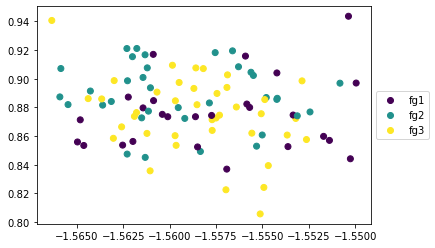

In [22]:
scatter = plt.scatter(attended_data[:,0],attended_data[:,1],c=labels_)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
           handles=scatter.legend_elements()[0],labels=("fg1","fg2","fg3"))

In [23]:
# scatter = plt.scatter(x[:,0],x[:,1],c=y)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
#            handles=scatter.legend_elements()[0],labels=("fg1","fg2","fg3","bg"))

In [24]:
# print(max_values)
# sorted_values,_ = torch.sort(non_max_values,descending=True)
# sorted_values[0,0:20]

In [25]:
# print(max_values_1)
# sorted_values,_ = torch.sort(non_max_values_1,descending=True)
# sorted_values[0,0:20]

In [26]:
# print(max_values_2)
# sorted_values,_ = torch.sort(non_max_values_2,descending=True)
# sorted_values[0,0:20]

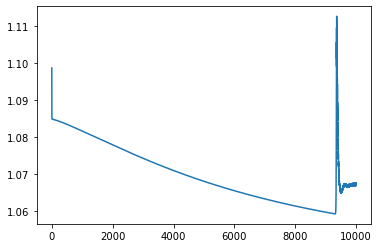

In [27]:
plt.plot(loss_list)

In [28]:
# attended_data

# hard attention

In [29]:
focus_net = Focus(input_dims = 2,attention="hard").double()
focus_net = focus_net.to(device)

classify = Classification(input_dims=2,output_dims=3).double()
classify = classify.to(device)

focus_net.apply(initialize_zeros_weights)
classify.apply(initialize_zeros_weights)
# parameters
for params in focus_net.parameters():
    print(params)
for params in classify.parameters():
    print(params)

Parameter containing:
tensor([[0., 0.]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([0., 0., 0.], dtype=torch.float64, requires_grad=True)


In [30]:
focus_net,classify,loss_list = train_attention_models(train_loader,focus_net,classify,
                           learning_rate=0.5,n_classes=3,nos_epochs=10000,attention="hard")

[1] loss: 1.099
[2] loss: 1.087
[3] loss: 1.085
[4] loss: 1.085
[5] loss: 1.085
[6] loss: 1.085
[7] loss: 1.085
[8] loss: 1.085
[9] loss: 1.085
[10] loss: 1.085
[11] loss: 1.085
[12] loss: 1.085
[13] loss: 1.085
[14] loss: 1.085
[15] loss: 1.085
[16] loss: 1.085
[17] loss: 1.085
[18] loss: 1.085
[19] loss: 1.085
[20] loss: 1.085
[21] loss: 1.085
[22] loss: 1.085
[23] loss: 1.085
[24] loss: 1.085
[25] loss: 1.085
[26] loss: 1.085
[27] loss: 1.085
[28] loss: 1.085
[29] loss: 1.085


/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


[30] loss: 1.085
[31] loss: 1.085
[32] loss: 1.085
[33] loss: 1.085
[34] loss: 1.085
[35] loss: 1.085
[36] loss: 1.085
[37] loss: 1.085
[38] loss: 1.085
[39] loss: 1.085
[40] loss: 1.085
[41] loss: 1.085
[42] loss: 1.085
[43] loss: 1.085
[44] loss: 1.085
[45] loss: 1.085
[46] loss: 1.085
[47] loss: 1.085
[48] loss: 1.085
[49] loss: 1.085
[50] loss: 1.085
[51] loss: 1.085
[52] loss: 1.085
[53] loss: 1.085
[54] loss: 1.085
[55] loss: 1.085
[56] loss: 1.085
[57] loss: 1.085
[58] loss: 1.085
[59] loss: 1.085
[60] loss: 1.085
[61] loss: 1.085
[62] loss: 1.085
[63] loss: 1.085
[64] loss: 1.085
[65] loss: 1.085
[66] loss: 1.085
[67] loss: 1.085
[68] loss: 1.085
[69] loss: 1.085
[70] loss: 1.085
[71] loss: 1.085
[72] loss: 1.085
[73] loss: 1.085
[74] loss: 1.085
[75] loss: 1.085
[76] loss: 1.085
[77] loss: 1.085
[78] loss: 1.085
[79] loss: 1.085
[80] loss: 1.085
[81] loss: 1.085
[82] loss: 1.085
[83] loss: 1.085
[84] loss: 1.085
[85] loss: 1.085
[86] loss: 1.085
[87] loss: 1.085
[88] loss: 1.0

[509] loss: 1.085
[510] loss: 1.085
[511] loss: 1.085
[512] loss: 1.085
[513] loss: 1.085
[514] loss: 1.085
[515] loss: 1.085
[516] loss: 1.085
[517] loss: 1.085
[518] loss: 1.085
[519] loss: 1.085
[520] loss: 1.085
[521] loss: 1.085
[522] loss: 1.085
[523] loss: 1.085
[524] loss: 1.085
[525] loss: 1.085
[526] loss: 1.085
[527] loss: 1.085
[528] loss: 1.085
[529] loss: 1.085
[530] loss: 1.085
[531] loss: 1.085
[532] loss: 1.085
[533] loss: 1.085
[534] loss: 1.085
[535] loss: 1.085
[536] loss: 1.085
[537] loss: 1.085
[538] loss: 1.085
[539] loss: 1.085
[540] loss: 1.085
[541] loss: 1.085
[542] loss: 1.085
[543] loss: 1.085
[544] loss: 1.085
[545] loss: 1.085
[546] loss: 1.085
[547] loss: 1.085
[548] loss: 1.085
[549] loss: 1.085
[550] loss: 1.085
[551] loss: 1.085
[552] loss: 1.085
[553] loss: 1.085
[554] loss: 1.085
[555] loss: 1.085
[556] loss: 1.085
[557] loss: 1.085
[558] loss: 1.085
[559] loss: 1.085
[560] loss: 1.085
[561] loss: 1.085
[562] loss: 1.085
[563] loss: 1.085
[564] loss

[996] loss: 1.085
[997] loss: 1.085
[998] loss: 1.085
[999] loss: 1.085
[1000] loss: 1.085
[1001] loss: 1.085
[1002] loss: 1.085
[1003] loss: 1.085
[1004] loss: 1.085
[1005] loss: 1.085
[1006] loss: 1.085
[1007] loss: 1.085
[1008] loss: 1.085
[1009] loss: 1.085
[1010] loss: 1.085
[1011] loss: 1.085
[1012] loss: 1.085
[1013] loss: 1.085
[1014] loss: 1.085
[1015] loss: 1.085
[1016] loss: 1.085
[1017] loss: 1.085
[1018] loss: 1.085
[1019] loss: 1.085
[1020] loss: 1.085
[1021] loss: 1.085
[1022] loss: 1.085
[1023] loss: 1.085
[1024] loss: 1.085
[1025] loss: 1.085
[1026] loss: 1.085
[1027] loss: 1.085
[1028] loss: 1.085
[1029] loss: 1.085
[1030] loss: 1.085
[1031] loss: 1.085
[1032] loss: 1.085
[1033] loss: 1.085
[1034] loss: 1.085
[1035] loss: 1.085
[1036] loss: 1.085
[1037] loss: 1.085
[1038] loss: 1.085
[1039] loss: 1.085
[1040] loss: 1.085
[1041] loss: 1.085
[1042] loss: 1.085
[1043] loss: 1.085
[1044] loss: 1.085
[1045] loss: 1.085
[1046] loss: 1.085
[1047] loss: 1.085
[1048] loss: 1.0

[1459] loss: 1.085
[1460] loss: 1.085
[1461] loss: 1.085
[1462] loss: 1.085
[1463] loss: 1.085
[1464] loss: 1.085
[1465] loss: 1.085
[1466] loss: 1.085
[1467] loss: 1.085
[1468] loss: 1.085
[1469] loss: 1.085
[1470] loss: 1.085
[1471] loss: 1.085
[1472] loss: 1.085
[1473] loss: 1.085
[1474] loss: 1.085
[1475] loss: 1.085
[1476] loss: 1.085
[1477] loss: 1.085
[1478] loss: 1.085
[1479] loss: 1.085
[1480] loss: 1.085
[1481] loss: 1.085
[1482] loss: 1.085
[1483] loss: 1.085
[1484] loss: 1.085
[1485] loss: 1.085
[1486] loss: 1.085
[1487] loss: 1.085
[1488] loss: 1.085
[1489] loss: 1.085
[1490] loss: 1.085
[1491] loss: 1.085
[1492] loss: 1.085
[1493] loss: 1.085
[1494] loss: 1.085
[1495] loss: 1.085
[1496] loss: 1.085
[1497] loss: 1.085
[1498] loss: 1.085
[1499] loss: 1.085
[1500] loss: 1.085
[1501] loss: 1.085
[1502] loss: 1.085
[1503] loss: 1.085
[1504] loss: 1.085
[1505] loss: 1.085
[1506] loss: 1.085
[1507] loss: 1.085
[1508] loss: 1.085
[1509] loss: 1.085
[1510] loss: 1.085
[1511] loss:

[1903] loss: 1.085
[1904] loss: 1.085
[1905] loss: 1.085
[1906] loss: 1.085
[1907] loss: 1.085
[1908] loss: 1.085
[1909] loss: 1.085
[1910] loss: 1.085
[1911] loss: 1.085
[1912] loss: 1.085
[1913] loss: 1.085
[1914] loss: 1.085
[1915] loss: 1.085
[1916] loss: 1.085
[1917] loss: 1.085
[1918] loss: 1.085
[1919] loss: 1.085
[1920] loss: 1.085
[1921] loss: 1.085
[1922] loss: 1.085
[1923] loss: 1.085
[1924] loss: 1.085
[1925] loss: 1.085
[1926] loss: 1.085
[1927] loss: 1.085
[1928] loss: 1.085
[1929] loss: 1.085
[1930] loss: 1.085
[1931] loss: 1.085
[1932] loss: 1.085
[1933] loss: 1.085
[1934] loss: 1.085
[1935] loss: 1.085
[1936] loss: 1.085
[1937] loss: 1.085
[1938] loss: 1.085
[1939] loss: 1.085
[1940] loss: 1.085
[1941] loss: 1.085
[1942] loss: 1.085
[1943] loss: 1.085
[1944] loss: 1.085
[1945] loss: 1.085
[1946] loss: 1.085
[1947] loss: 1.085
[1948] loss: 1.085
[1949] loss: 1.085
[1950] loss: 1.085
[1951] loss: 1.085
[1952] loss: 1.085
[1953] loss: 1.085
[1954] loss: 1.085
[1955] loss:

[2346] loss: 1.085
[2347] loss: 1.085
[2348] loss: 1.085
[2349] loss: 1.085
[2350] loss: 1.085
[2351] loss: 1.085
[2352] loss: 1.085
[2353] loss: 1.085
[2354] loss: 1.085
[2355] loss: 1.085
[2356] loss: 1.085
[2357] loss: 1.085
[2358] loss: 1.085
[2359] loss: 1.085
[2360] loss: 1.085
[2361] loss: 1.085
[2362] loss: 1.085
[2363] loss: 1.085
[2364] loss: 1.085
[2365] loss: 1.085
[2366] loss: 1.085
[2367] loss: 1.085
[2368] loss: 1.085
[2369] loss: 1.085
[2370] loss: 1.085
[2371] loss: 1.085
[2372] loss: 1.085
[2373] loss: 1.085
[2374] loss: 1.085
[2375] loss: 1.085
[2376] loss: 1.085
[2377] loss: 1.085
[2378] loss: 1.085
[2379] loss: 1.085
[2380] loss: 1.085
[2381] loss: 1.085
[2382] loss: 1.085
[2383] loss: 1.085
[2384] loss: 1.085
[2385] loss: 1.085
[2386] loss: 1.085
[2387] loss: 1.085
[2388] loss: 1.085
[2389] loss: 1.085
[2390] loss: 1.085
[2391] loss: 1.085
[2392] loss: 1.085
[2393] loss: 1.085
[2394] loss: 1.085
[2395] loss: 1.085
[2396] loss: 1.085
[2397] loss: 1.085
[2398] loss:

[2786] loss: 1.085
[2787] loss: 1.085
[2788] loss: 1.085
[2789] loss: 1.085
[2790] loss: 1.085
[2791] loss: 1.085
[2792] loss: 1.085
[2793] loss: 1.085
[2794] loss: 1.085
[2795] loss: 1.085
[2796] loss: 1.085
[2797] loss: 1.085
[2798] loss: 1.085
[2799] loss: 1.085
[2800] loss: 1.085
[2801] loss: 1.085
[2802] loss: 1.085
[2803] loss: 1.085
[2804] loss: 1.085
[2805] loss: 1.085
[2806] loss: 1.085
[2807] loss: 1.085
[2808] loss: 1.085
[2809] loss: 1.085
[2810] loss: 1.085
[2811] loss: 1.085
[2812] loss: 1.085
[2813] loss: 1.085
[2814] loss: 1.085
[2815] loss: 1.085
[2816] loss: 1.085
[2817] loss: 1.085
[2818] loss: 1.085
[2819] loss: 1.085
[2820] loss: 1.085
[2821] loss: 1.085
[2822] loss: 1.085
[2823] loss: 1.085
[2824] loss: 1.085
[2825] loss: 1.085
[2826] loss: 1.085
[2827] loss: 1.085
[2828] loss: 1.085
[2829] loss: 1.085
[2830] loss: 1.085
[2831] loss: 1.085
[2832] loss: 1.085
[2833] loss: 1.085
[2834] loss: 1.085
[2835] loss: 1.085
[2836] loss: 1.085
[2837] loss: 1.085
[2838] loss:

[3241] loss: 1.085
[3242] loss: 1.085
[3243] loss: 1.085
[3244] loss: 1.085
[3245] loss: 1.085
[3246] loss: 1.085
[3247] loss: 1.085
[3248] loss: 1.085
[3249] loss: 1.085
[3250] loss: 1.085
[3251] loss: 1.085
[3252] loss: 1.085
[3253] loss: 1.085
[3254] loss: 1.085
[3255] loss: 1.085
[3256] loss: 1.085
[3257] loss: 1.085
[3258] loss: 1.085
[3259] loss: 1.085
[3260] loss: 1.085
[3261] loss: 1.085
[3262] loss: 1.085
[3263] loss: 1.085
[3264] loss: 1.085
[3265] loss: 1.085
[3266] loss: 1.085
[3267] loss: 1.085
[3268] loss: 1.085
[3269] loss: 1.085
[3270] loss: 1.085
[3271] loss: 1.085
[3272] loss: 1.085
[3273] loss: 1.085
[3274] loss: 1.085
[3275] loss: 1.085
[3276] loss: 1.085
[3277] loss: 1.085
[3278] loss: 1.085
[3279] loss: 1.085
[3280] loss: 1.085
[3281] loss: 1.085
[3282] loss: 1.085
[3283] loss: 1.085
[3284] loss: 1.085
[3285] loss: 1.085
[3286] loss: 1.085
[3287] loss: 1.085
[3288] loss: 1.085
[3289] loss: 1.085
[3290] loss: 1.085
[3291] loss: 1.085
[3292] loss: 1.085
[3293] loss:

[3691] loss: 1.085
[3692] loss: 1.085
[3693] loss: 1.085
[3694] loss: 1.085
[3695] loss: 1.085
[3696] loss: 1.085
[3697] loss: 1.085
[3698] loss: 1.085
[3699] loss: 1.085
[3700] loss: 1.085
[3701] loss: 1.085
[3702] loss: 1.085
[3703] loss: 1.085
[3704] loss: 1.085
[3705] loss: 1.085
[3706] loss: 1.085
[3707] loss: 1.085
[3708] loss: 1.085
[3709] loss: 1.085
[3710] loss: 1.085
[3711] loss: 1.085
[3712] loss: 1.085
[3713] loss: 1.085
[3714] loss: 1.085
[3715] loss: 1.085
[3716] loss: 1.085
[3717] loss: 1.085
[3718] loss: 1.085
[3719] loss: 1.085
[3720] loss: 1.085
[3721] loss: 1.085
[3722] loss: 1.085
[3723] loss: 1.085
[3724] loss: 1.085
[3725] loss: 1.085
[3726] loss: 1.085
[3727] loss: 1.085
[3728] loss: 1.085
[3729] loss: 1.085
[3730] loss: 1.085
[3731] loss: 1.085
[3732] loss: 1.085
[3733] loss: 1.085
[3734] loss: 1.085
[3735] loss: 1.085
[3736] loss: 1.085
[3737] loss: 1.085
[3738] loss: 1.085
[3739] loss: 1.085
[3740] loss: 1.085
[3741] loss: 1.085
[3742] loss: 1.085
[3743] loss:

[4137] loss: 1.085
[4138] loss: 1.085
[4139] loss: 1.085
[4140] loss: 1.085
[4141] loss: 1.085
[4142] loss: 1.085
[4143] loss: 1.085
[4144] loss: 1.085
[4145] loss: 1.085
[4146] loss: 1.085
[4147] loss: 1.085
[4148] loss: 1.085
[4149] loss: 1.085
[4150] loss: 1.085
[4151] loss: 1.085
[4152] loss: 1.085
[4153] loss: 1.085
[4154] loss: 1.085
[4155] loss: 1.085
[4156] loss: 1.085
[4157] loss: 1.085
[4158] loss: 1.085
[4159] loss: 1.085
[4160] loss: 1.085
[4161] loss: 1.085
[4162] loss: 1.085
[4163] loss: 1.085
[4164] loss: 1.085
[4165] loss: 1.085
[4166] loss: 1.085
[4167] loss: 1.085
[4168] loss: 1.085
[4169] loss: 1.085
[4170] loss: 1.085
[4171] loss: 1.085
[4172] loss: 1.085
[4173] loss: 1.085
[4174] loss: 1.085
[4175] loss: 1.085
[4176] loss: 1.085
[4177] loss: 1.085
[4178] loss: 1.085
[4179] loss: 1.085
[4180] loss: 1.085
[4181] loss: 1.085
[4182] loss: 1.085
[4183] loss: 1.085
[4184] loss: 1.085
[4185] loss: 1.085
[4186] loss: 1.085
[4187] loss: 1.085
[4188] loss: 1.085
[4189] loss:

[4569] loss: 1.085
[4570] loss: 1.085
[4571] loss: 1.085
[4572] loss: 1.085
[4573] loss: 1.085
[4574] loss: 1.085
[4575] loss: 1.085
[4576] loss: 1.085
[4577] loss: 1.085
[4578] loss: 1.085
[4579] loss: 1.085
[4580] loss: 1.085
[4581] loss: 1.085
[4582] loss: 1.085
[4583] loss: 1.085
[4584] loss: 1.085
[4585] loss: 1.085
[4586] loss: 1.085
[4587] loss: 1.085
[4588] loss: 1.085
[4589] loss: 1.085
[4590] loss: 1.085
[4591] loss: 1.085
[4592] loss: 1.085
[4593] loss: 1.085
[4594] loss: 1.085
[4595] loss: 1.085
[4596] loss: 1.085
[4597] loss: 1.085
[4598] loss: 1.085
[4599] loss: 1.085
[4600] loss: 1.085
[4601] loss: 1.085
[4602] loss: 1.085
[4603] loss: 1.085
[4604] loss: 1.085
[4605] loss: 1.085
[4606] loss: 1.085
[4607] loss: 1.085
[4608] loss: 1.085
[4609] loss: 1.085
[4610] loss: 1.085
[4611] loss: 1.085
[4612] loss: 1.085
[4613] loss: 1.085
[4614] loss: 1.085
[4615] loss: 1.085
[4616] loss: 1.085
[4617] loss: 1.085
[4618] loss: 1.085
[4619] loss: 1.085
[4620] loss: 1.085
[4621] loss:

[5008] loss: 1.085
[5009] loss: 1.085
[5010] loss: 1.085
[5011] loss: 1.085
[5012] loss: 1.085
[5013] loss: 1.085
[5014] loss: 1.085
[5015] loss: 1.085
[5016] loss: 1.085
[5017] loss: 1.085
[5018] loss: 1.085
[5019] loss: 1.085
[5020] loss: 1.085
[5021] loss: 1.085
[5022] loss: 1.085
[5023] loss: 1.085
[5024] loss: 1.085
[5025] loss: 1.085
[5026] loss: 1.085
[5027] loss: 1.085
[5028] loss: 1.085
[5029] loss: 1.085
[5030] loss: 1.085
[5031] loss: 1.085
[5032] loss: 1.085
[5033] loss: 1.085
[5034] loss: 1.085
[5035] loss: 1.085
[5036] loss: 1.085
[5037] loss: 1.085
[5038] loss: 1.085
[5039] loss: 1.085
[5040] loss: 1.085
[5041] loss: 1.085
[5042] loss: 1.085
[5043] loss: 1.085
[5044] loss: 1.085
[5045] loss: 1.085
[5046] loss: 1.085
[5047] loss: 1.085
[5048] loss: 1.085
[5049] loss: 1.085
[5050] loss: 1.085
[5051] loss: 1.085
[5052] loss: 1.085
[5053] loss: 1.085
[5054] loss: 1.085
[5055] loss: 1.085
[5056] loss: 1.085
[5057] loss: 1.085
[5058] loss: 1.085
[5059] loss: 1.085
[5060] loss:

[5462] loss: 1.085
[5463] loss: 1.085
[5464] loss: 1.085
[5465] loss: 1.085
[5466] loss: 1.085
[5467] loss: 1.085
[5468] loss: 1.085
[5469] loss: 1.085
[5470] loss: 1.085
[5471] loss: 1.085
[5472] loss: 1.085
[5473] loss: 1.085
[5474] loss: 1.085
[5475] loss: 1.085
[5476] loss: 1.085
[5477] loss: 1.085
[5478] loss: 1.085
[5479] loss: 1.085
[5480] loss: 1.085
[5481] loss: 1.085
[5482] loss: 1.085
[5483] loss: 1.085
[5484] loss: 1.085
[5485] loss: 1.085
[5486] loss: 1.085
[5487] loss: 1.085
[5488] loss: 1.085
[5489] loss: 1.085
[5490] loss: 1.085
[5491] loss: 1.085
[5492] loss: 1.085
[5493] loss: 1.085
[5494] loss: 1.085
[5495] loss: 1.085
[5496] loss: 1.085
[5497] loss: 1.085
[5498] loss: 1.085
[5499] loss: 1.085
[5500] loss: 1.085
[5501] loss: 1.085
[5502] loss: 1.085
[5503] loss: 1.085
[5504] loss: 1.085
[5505] loss: 1.085
[5506] loss: 1.085
[5507] loss: 1.085
[5508] loss: 1.085
[5509] loss: 1.085
[5510] loss: 1.085
[5511] loss: 1.085
[5512] loss: 1.085
[5513] loss: 1.085
[5514] loss:

[5920] loss: 1.085
[5921] loss: 1.085
[5922] loss: 1.085
[5923] loss: 1.085
[5924] loss: 1.085
[5925] loss: 1.085
[5926] loss: 1.085
[5927] loss: 1.085
[5928] loss: 1.085
[5929] loss: 1.085
[5930] loss: 1.085
[5931] loss: 1.085
[5932] loss: 1.085
[5933] loss: 1.085
[5934] loss: 1.085
[5935] loss: 1.085
[5936] loss: 1.085
[5937] loss: 1.085
[5938] loss: 1.085
[5939] loss: 1.085
[5940] loss: 1.085
[5941] loss: 1.085
[5942] loss: 1.085
[5943] loss: 1.085
[5944] loss: 1.085
[5945] loss: 1.085
[5946] loss: 1.085
[5947] loss: 1.085
[5948] loss: 1.085
[5949] loss: 1.085
[5950] loss: 1.085
[5951] loss: 1.085
[5952] loss: 1.085
[5953] loss: 1.085
[5954] loss: 1.085
[5955] loss: 1.085
[5956] loss: 1.085
[5957] loss: 1.085
[5958] loss: 1.085
[5959] loss: 1.085
[5960] loss: 1.085
[5961] loss: 1.085
[5962] loss: 1.085
[5963] loss: 1.085
[5964] loss: 1.085
[5965] loss: 1.085
[5966] loss: 1.085
[5967] loss: 1.085
[5968] loss: 1.085
[5969] loss: 1.085
[5970] loss: 1.085
[5971] loss: 1.085
[5972] loss:

[6363] loss: 1.085
[6364] loss: 1.085
[6365] loss: 1.085
[6366] loss: 1.085
[6367] loss: 1.085
[6368] loss: 1.085
[6369] loss: 1.085
[6370] loss: 1.085
[6371] loss: 1.085
[6372] loss: 1.085
[6373] loss: 1.085
[6374] loss: 1.085
[6375] loss: 1.085
[6376] loss: 1.085
[6377] loss: 1.085
[6378] loss: 1.085
[6379] loss: 1.085
[6380] loss: 1.085
[6381] loss: 1.085
[6382] loss: 1.085
[6383] loss: 1.085
[6384] loss: 1.085
[6385] loss: 1.085
[6386] loss: 1.085
[6387] loss: 1.085
[6388] loss: 1.085
[6389] loss: 1.085
[6390] loss: 1.085
[6391] loss: 1.085
[6392] loss: 1.085
[6393] loss: 1.085
[6394] loss: 1.085
[6395] loss: 1.085
[6396] loss: 1.085
[6397] loss: 1.085
[6398] loss: 1.085
[6399] loss: 1.085
[6400] loss: 1.085
[6401] loss: 1.085
[6402] loss: 1.085
[6403] loss: 1.085
[6404] loss: 1.085
[6405] loss: 1.085
[6406] loss: 1.085
[6407] loss: 1.085
[6408] loss: 1.085
[6409] loss: 1.085
[6410] loss: 1.085
[6411] loss: 1.085
[6412] loss: 1.085
[6413] loss: 1.085
[6414] loss: 1.085
[6415] loss:

[6821] loss: 1.085
[6822] loss: 1.085
[6823] loss: 1.085
[6824] loss: 1.085
[6825] loss: 1.085
[6826] loss: 1.085
[6827] loss: 1.085
[6828] loss: 1.085
[6829] loss: 1.085
[6830] loss: 1.085
[6831] loss: 1.085
[6832] loss: 1.085
[6833] loss: 1.085
[6834] loss: 1.085
[6835] loss: 1.085
[6836] loss: 1.085
[6837] loss: 1.085
[6838] loss: 1.085
[6839] loss: 1.085
[6840] loss: 1.085
[6841] loss: 1.085
[6842] loss: 1.085
[6843] loss: 1.085
[6844] loss: 1.085
[6845] loss: 1.085
[6846] loss: 1.085
[6847] loss: 1.085
[6848] loss: 1.085
[6849] loss: 1.085
[6850] loss: 1.085
[6851] loss: 1.085
[6852] loss: 1.085
[6853] loss: 1.085
[6854] loss: 1.085
[6855] loss: 1.085
[6856] loss: 1.085
[6857] loss: 1.085
[6858] loss: 1.085
[6859] loss: 1.085
[6860] loss: 1.085
[6861] loss: 1.085
[6862] loss: 1.085
[6863] loss: 1.085
[6864] loss: 1.085
[6865] loss: 1.085
[6866] loss: 1.085
[6867] loss: 1.085
[6868] loss: 1.085
[6869] loss: 1.085
[6870] loss: 1.085
[6871] loss: 1.085
[6872] loss: 1.085
[6873] loss:

[7256] loss: 1.084
[7257] loss: 1.084
[7258] loss: 1.084
[7259] loss: 1.084
[7260] loss: 1.084
[7261] loss: 1.084
[7262] loss: 1.084
[7263] loss: 1.084
[7264] loss: 1.084
[7265] loss: 1.084
[7266] loss: 1.084
[7267] loss: 1.084
[7268] loss: 1.084
[7269] loss: 1.084
[7270] loss: 1.084
[7271] loss: 1.084
[7272] loss: 1.084
[7273] loss: 1.084
[7274] loss: 1.084
[7275] loss: 1.084
[7276] loss: 1.084
[7277] loss: 1.084
[7278] loss: 1.084
[7279] loss: 1.084
[7280] loss: 1.084
[7281] loss: 1.084
[7282] loss: 1.084
[7283] loss: 1.084
[7284] loss: 1.084
[7285] loss: 1.084
[7286] loss: 1.084
[7287] loss: 1.084
[7288] loss: 1.084
[7289] loss: 1.084
[7290] loss: 1.084
[7291] loss: 1.084
[7292] loss: 1.084
[7293] loss: 1.084
[7294] loss: 1.084
[7295] loss: 1.084
[7296] loss: 1.084
[7297] loss: 1.084
[7298] loss: 1.084
[7299] loss: 1.084
[7300] loss: 1.084
[7301] loss: 1.084
[7302] loss: 1.084
[7303] loss: 1.084
[7304] loss: 1.084
[7305] loss: 1.084
[7306] loss: 1.084
[7307] loss: 1.084
[7308] loss:

[7698] loss: 0.082
[7699] loss: 0.081
[7700] loss: 0.080
[7701] loss: 0.079
[7702] loss: 0.078
[7703] loss: 0.076
[7704] loss: 0.075
[7705] loss: 0.074
[7706] loss: 0.073
[7707] loss: 0.073
[7708] loss: 0.072
[7709] loss: 0.071
[7710] loss: 0.070
[7711] loss: 0.069
[7712] loss: 0.068
[7713] loss: 0.067
[7714] loss: 0.067
[7715] loss: 0.066
[7716] loss: 0.065
[7717] loss: 0.064
[7718] loss: 0.064
[7719] loss: 0.063
[7720] loss: 0.062
[7721] loss: 0.061
[7722] loss: 0.061
[7723] loss: 0.060
[7724] loss: 0.059
[7725] loss: 0.059
[7726] loss: 0.058
[7727] loss: 0.058
[7728] loss: 0.057
[7729] loss: 0.056
[7730] loss: 0.056
[7731] loss: 0.055
[7732] loss: 0.055
[7733] loss: 0.054
[7734] loss: 0.054
[7735] loss: 0.053
[7736] loss: 0.053
[7737] loss: 0.052
[7738] loss: 0.052
[7739] loss: 0.051
[7740] loss: 0.051
[7741] loss: 0.050
[7742] loss: 0.050
[7743] loss: 0.049
[7744] loss: 0.049
[7745] loss: 0.049
[7746] loss: 0.048
[7747] loss: 0.048
[7748] loss: 0.047
[7749] loss: 0.047
[7750] loss:

[8150] loss: 0.011
[8151] loss: 0.011
[8152] loss: 0.010
[8153] loss: 0.010
[8154] loss: 0.010
[8155] loss: 0.010
[8156] loss: 0.010
[8157] loss: 0.010
[8158] loss: 0.010
[8159] loss: 0.010
[8160] loss: 0.010
[8161] loss: 0.010
[8162] loss: 0.010
[8163] loss: 0.010
[8164] loss: 0.010
[8165] loss: 0.010
[8166] loss: 0.010
[8167] loss: 0.010
[8168] loss: 0.010
[8169] loss: 0.010
[8170] loss: 0.010
[8171] loss: 0.010
[8172] loss: 0.010
[8173] loss: 0.010
[8174] loss: 0.010
[8175] loss: 0.010
[8176] loss: 0.010
[8177] loss: 0.010
[8178] loss: 0.010
Finished Training


In [31]:
save_analysis(train_loader,test_loader,focus_net,classify,3) # ftpt ffpt ftpf ffpf

([100, 0, 0, 0], [1000, 0, 0, 0])

In [32]:
attended_data = []
labels_ = []
focus_net.eval()
classify.eval()
with torch.no_grad():
    for i, data in  enumerate(train_loader):
        inputs , labels , fore_idx = data
        batch = inputs.size(0)
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.double()
        labels_.append(labels.numpy())
        # zero the parameter gradients
        alphas, avg_images = focus_net(inputs)
        max_values,_ = torch.max(alphas[labels==0],dim=1)
        non_max_values,_ = torch.topk(alphas[labels==0],k=99,largest=False)
        #print(alphas[np.arange(alphas.shape[0]),torch.argmax(alphas,dim=1)],torch.argmax(alphas,dim=1),fore_idx)
        outputs = torch.sigmoid(classify(avg_images))
        attended_data.append(avg_images.numpy())
#         loss = my_cross_entropy(outputs[:,0], labels.double(),alphas) 

In [33]:
attended_data = np.concatenate(attended_data,axis=0)
# labels_ = np.concatenate(labels_,axis=0)

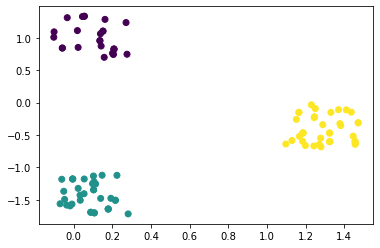

In [34]:
plt.scatter(attended_data[:,0],attended_data[:,1],c=labels_)

In [35]:
print(max_values)
sorted_values,_ = torch.sort(non_max_values,descending=True)
sorted_values[:,0:10]

tensor([0.9651, 0.8468, 0.7692, 0.8924, 0.8086, 0.9459, 0.8780, 0.9804, 0.8516,
        0.7817, 0.9297, 0.9480, 0.9567, 0.9559, 0.9774, 0.8740, 0.9783, 0.9820,
        0.9288, 0.9779, 0.9813, 0.9686, 0.9783, 0.9884, 0.8454, 0.9478],
       dtype=torch.float64)


tensor([[6.7041e-06, 6.7041e-06, 6.7041e-06, 6.7041e-06, 6.7041e-06, 6.7041e-06,
         5.6069e-06, 5.6069e-06, 5.6069e-06, 5.6069e-06],
        [3.1572e-05, 3.1572e-05, 3.1572e-05, 3.1572e-05, 2.8866e-05, 2.8866e-05,
         2.8866e-05, 2.8866e-05, 2.8866e-05, 2.8866e-05],
        [4.6125e-05, 4.6125e-05, 4.2172e-05, 4.2172e-05, 4.2172e-05, 4.2172e-05,
         4.2172e-05, 4.2172e-05, 4.2172e-05, 4.2172e-05],
        [2.3485e-05, 2.3485e-05, 2.3485e-05, 2.3485e-05, 2.3485e-05, 2.1472e-05,
         2.1472e-05, 2.1472e-05, 2.1472e-05, 2.1472e-05],
        [3.0860e-05, 3.0860e-05, 3.0860e-05, 3.0860e-05, 3.0860e-05, 3.0860e-05,
         3.0860e-05, 2.9785e-05, 2.9785e-05, 2.9785e-05],
        [1.0970e-05, 1.0030e-05, 1.0030e-05, 1.0030e-05, 1.0030e-05, 1.0030e-05,
         1.0030e-05, 1.0030e-05, 1.0030e-05, 1.0030e-05],
        [2.3543e-05, 2.3107e-05, 2.3107e-05, 2.3107e-05, 2.3107e-05, 2.3107e-05,
         2.3107e-05, 2.1126e-05, 2.1126e-05, 2.1126e-05],
        [3.6708e-06, 3.6708

In [36]:
for params in focus_net.parameters():
    print(params)
for params in classify.parameters():
    print(params)

Parameter containing:
tensor([[ 6.5158, -2.1100]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([[-2.4821,  3.2314],
        [-1.7409, -3.3580],
        [ 4.2229,  0.1266]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([ 1.7860, -0.4959, -1.2901], dtype=torch.float64, requires_grad=True)


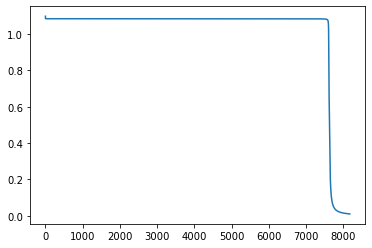

In [37]:
plt.plot(loss_list)

# train a max-margin classifier

In [38]:
fg_bg_labels = np.ones(y.shape)
fg_bg_labels[np.where(y==3)] = 0

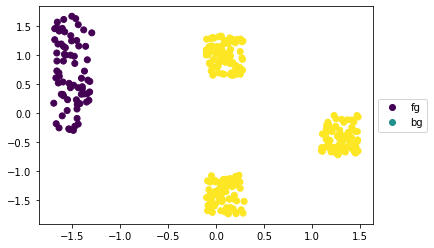

In [39]:
plt.scatter(x[:,0],x[:,1],c=fg_bg_labels)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
           handles=scatter.legend_elements()[0],labels=("fg","bg"))

In [40]:
from sklearn.svm import LinearSVC

clf = LinearSVC(random_state=0,fit_intercept=True)
clf.fit(x,fg_bg_labels)

LinearSVC(random_state=0)

In [41]:
sum(clf.predict(x) == fg_bg_labels)

300

In [42]:
clf.coef_,clf.intercept_

(array([[ 1.49467446, -0.00920422]]), array([1.06334517]))

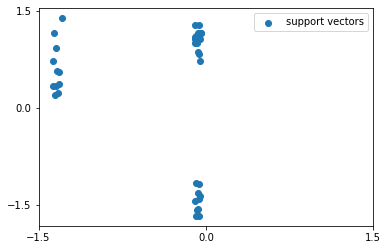

In [43]:
decision_function = clf.decision_function(x)
support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
support_vectors = x[support_vector_indices]
plt.scatter(support_vectors[:,0],support_vectors[:,1],label="support vectors")
plt.xticks([-1.5,0.0,1.5])
plt.yticks([-1.5,0.0,1.5])
plt.legend()


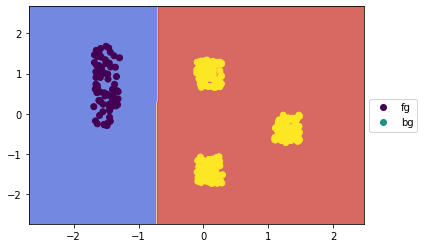

In [44]:
# create a mesh to plot in
h = 0.02
x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(x[:,0],x[:,1],c=fg_bg_labels)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
           handles=scatter.legend_elements()[0],labels=("fg","bg"))


In [45]:
beta = torch.tensor([0,0.01,0.02,0.04,0.08,0.16,0.32,0.50,0.64,1,1.28,2.56,5.12])
directions = torch.tensor([[1,0],[1/np.sqrt(2),1/np.sqrt(2)],[0,1],
              [-1/np.sqrt(2),1/np.sqrt(2)],[-1,0],[-1/np.sqrt(2),-1/np.sqrt(2)],[0,-1],[1/np.sqrt(2),-1/np.sqrt(2)]])

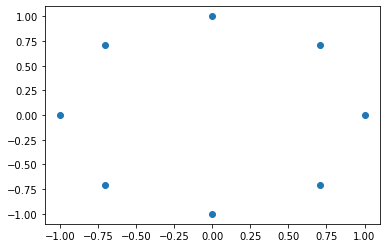

In [46]:
plt.scatter(directions[:,0],directions[:,1])

In [47]:
def generate_attended_data(trainloader,focus,focus_direction=None):
    attended_data = []
    attended_labels = []
    for i, data in  enumerate(trainloader):
        inputs , labels , fore_idx = data
        batch = inputs.size(0)
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.double()
        if focus_direction is None:
            alphas, avg_data = focus(inputs)
        else:
            z = inputs
            batch = z.size(0)
            patches = z.size(1)
            dims = z.size(2)
            z = z.view(batch,patches,dims)
            alp1,ft1 = focus.helper(z)
            alp2,ft2 = focus_direction.helper(z)
            alp3 = alp1 + alp2
            alpha = F.softmax(alp3,dim=1)
            y = torch.sum(alpha*ft1,dim=1)
            alpha =alpha[:,:,0]
            avg_data = y
            
            
        attended_data.append(avg_data)
        attended_labels.append(labels)
    attended_data = torch.cat(attended_data,dim=0)
    attended_labels = torch.cat(attended_labels,dim=0)
    #plt.figure()
    #plt.scatter(attended_data[:,0],attended_data[:,1],c=attended_labels)
    return attended_data,attended_labels
        
    

In [48]:
def calculate_loss(data,labels,net,criterion):
    net.eval()
    with torch.no_grad():
        outputs = net(data)
        loss = criterion(outputs,labels)
    return loss.item()
        
        
        

In [49]:
def train_classification_model(attended_data,attended_labels, classify_model,n_classes,test_list,learning_rate=0.01):
    nos_epochs = 300
    if n_classes > 2:
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.BCELoss()
    optimizer_classify = optim.SGD(classify_model.parameters(), lr=learning_rate)#,  momentum=0.09)
    loss_list=[]
    test_loss_list = []
    #print("ddd",attended_data,attended_labels)
    #print("sss",test_list[0])
    
    with torch.no_grad():
        test_loss_epoch  = [] 
        epoch_loss = []
        
        # for train data at epoch zero
        outputs = classify_model(attended_data)
        loss = criterion(outputs,attended_labels)
        epoch_loss.append(loss.item())
        # for test data at epoch zero
        test_loss_epoch  = [] 
        for data in test_list:
            test_inputs,test_labels = data
            classify_model.eval()
            test_outputs = classify_model(test_inputs)
            test_loss = criterion(test_outputs,test_labels)
            test_loss_epoch.append(test_loss.item())
        test_loss_list.append(test_loss_epoch)
    loss_list.append(np.mean(epoch_loss))
        
    
    
    for epoch in range(nos_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_loss = []
        test_loss_epoch  = [] 
        classify_model.train()
        # zero the parameter gradients
        optimizer_classify.zero_grad()
        outputs = classify_model(attended_data)
        #print(outputs.shape)
        # predicted values
        if n_classes > 2:
            _,predicted= torch.max(outputs,dim=1)
        else:
            predicted = (outputs.data[:,0]>0.5).type(torch.int64)
        loss = criterion(outputs,attended_labels)
        loss.backward()
        optimizer_classify.step()
        
        loss_ = calculate_loss(attended_data,attended_labels,classify_model,criterion)
        epoch_loss.append(loss_)
        print('[%d] loss: %.3f' %(epoch + 1, np.mean(epoch_loss)))
        loss_list.append(np.mean(epoch_loss))
        # loss for test list, At every epoch for every direction perform forward pass and calculate loss
        for data in test_list:
            test_inputs,test_labels = data
            test_loss = calculate_loss(test_inputs,test_labels,classify_model,criterion)
            test_loss_epoch.append(test_loss)
        test_loss_list.append(test_loss_epoch)    
        if(np.mean(epoch_loss) <= 0.01):
            break    
    print('Finished Training')
    print(len(loss_list),len(test_loss_list))
    return classify_model,loss_list,test_loss_list
    
    

In [50]:
weight = torch.tensor([[1.49467446, -0.00920422]],dtype=torch.float64)
weight = weight/torch.linalg.norm(weight)
print(torch.linalg.norm(weight))
loss_beta = []
test_loss_beta = []
for beta_ in beta:
    focus_net = Focus(input_dims = 2,attention="soft").double()
    focus_net = focus_net.to(device)
    focus_net.fc1.weight.data = beta_*weight
    focus_net.fc1.weight.requires_grad = False
    

    
    classify = Classification(input_dims=2,output_dims=3).double()
    classify.apply(initialize_zeros_weights)
    classify = classify.to(device)
    

    
    print("Parameters")
    
    for params in focus_net.named_parameters():
        print(params)
    
    # attended data for focus model 
    f_attended_data,f_labels = generate_attended_data(train_loader,focus_net)
    
    # test attended data for focus model with 8 directions
    test_attended_data = []
    test_attended_data.append([f_attended_data,f_labels])
    
    for u in directions:
        focus_net_direction = Focus(input_dims = 2,attention="soft").double()
        focus_net_direction = focus_net_direction.to(device)
        focus_net_direction.fc1.weight.data = 0.01*u[None,:]
        focus_net_direction.fc1.weight.requires_grad = False
        d_attended_data,d_labels = generate_attended_data(train_loader,focus_net,focus_net_direction)

        test_attended_data.append([d_attended_data,d_labels])

        
        
    
    _,loss_list,test_loss_list = train_classification_model(f_attended_data,f_labels,classify,
                                             n_classes=3,test_list=test_attended_data,learning_rate=0.5)
    
    test_loss_list = np.array(test_loss_list)
    
    loss_beta.append(loss_list)
    test_loss_beta.append(test_loss_list)
        
    

    

tensor(1.0000, dtype=torch.float64)
Parameters
('fc1.weight', Parameter containing:
tensor([[0., -0.]], dtype=torch.float64))
[1] loss: 1.087
[2] loss: 1.085
[3] loss: 1.085
[4] loss: 1.085
[5] loss: 1.085
[6] loss: 1.085
[7] loss: 1.085
[8] loss: 1.085
[9] loss: 1.085
[10] loss: 1.085
[11] loss: 1.085
[12] loss: 1.085
[13] loss: 1.085
[14] loss: 1.085
[15] loss: 1.085
[16] loss: 1.085
[17] loss: 1.085
[18] loss: 1.085
[19] loss: 1.085
[20] loss: 1.085
[21] loss: 1.085
[22] loss: 1.085
[23] loss: 1.085
[24] loss: 1.085
[25] loss: 1.085
[26] loss: 1.085
[27] loss: 1.085
[28] loss: 1.085
[29] loss: 1.085
[30] loss: 1.085
[31] loss: 1.085
[32] loss: 1.085
[33] loss: 1.085
[34] loss: 1.085
[35] loss: 1.085
[36] loss: 1.085
[37] loss: 1.085
[38] loss: 1.085
[39] loss: 1.085
[40] loss: 1.085
[41] loss: 1.085
[42] loss: 1.085
[43] loss: 1.085
[44] loss: 1.085
[45] loss: 1.085
[46] loss: 1.085
[47] loss: 1.085
[48] loss: 1.085
[49] loss: 1.085
[50] loss: 1.085
[51] loss: 1.085
[52] loss: 1.085

[242] loss: 1.084
[243] loss: 1.084
[244] loss: 1.084
[245] loss: 1.084
[246] loss: 1.084
[247] loss: 1.084
[248] loss: 1.084
[249] loss: 1.084
[250] loss: 1.084
[251] loss: 1.084
[252] loss: 1.084
[253] loss: 1.084
[254] loss: 1.084
[255] loss: 1.084
[256] loss: 1.084
[257] loss: 1.084
[258] loss: 1.084
[259] loss: 1.084
[260] loss: 1.084
[261] loss: 1.084
[262] loss: 1.084
[263] loss: 1.084
[264] loss: 1.084
[265] loss: 1.084
[266] loss: 1.084
[267] loss: 1.084
[268] loss: 1.084
[269] loss: 1.084
[270] loss: 1.084
[271] loss: 1.084
[272] loss: 1.084
[273] loss: 1.084
[274] loss: 1.084
[275] loss: 1.084
[276] loss: 1.084
[277] loss: 1.084
[278] loss: 1.084
[279] loss: 1.084
[280] loss: 1.084
[281] loss: 1.084
[282] loss: 1.084
[283] loss: 1.084
[284] loss: 1.084
[285] loss: 1.084
[286] loss: 1.084
[287] loss: 1.084
[288] loss: 1.084
[289] loss: 1.084
[290] loss: 1.084
[291] loss: 1.084
[292] loss: 1.084
[293] loss: 1.084
[294] loss: 1.084
[295] loss: 1.084
[296] loss: 1.084
[297] loss

[207] loss: 1.084
[208] loss: 1.084
[209] loss: 1.084
[210] loss: 1.084
[211] loss: 1.084
[212] loss: 1.084
[213] loss: 1.084
[214] loss: 1.084
[215] loss: 1.084
[216] loss: 1.084
[217] loss: 1.084
[218] loss: 1.084
[219] loss: 1.084
[220] loss: 1.084
[221] loss: 1.084
[222] loss: 1.084
[223] loss: 1.084
[224] loss: 1.084
[225] loss: 1.084
[226] loss: 1.084
[227] loss: 1.084
[228] loss: 1.084
[229] loss: 1.084
[230] loss: 1.084
[231] loss: 1.084
[232] loss: 1.084
[233] loss: 1.084
[234] loss: 1.084
[235] loss: 1.084
[236] loss: 1.084
[237] loss: 1.084
[238] loss: 1.084
[239] loss: 1.084
[240] loss: 1.084
[241] loss: 1.084
[242] loss: 1.084
[243] loss: 1.084
[244] loss: 1.084
[245] loss: 1.084
[246] loss: 1.084
[247] loss: 1.084
[248] loss: 1.084
[249] loss: 1.084
[250] loss: 1.084
[251] loss: 1.084
[252] loss: 1.084
[253] loss: 1.084
[254] loss: 1.084
[255] loss: 1.084
[256] loss: 1.084
[257] loss: 1.084
[258] loss: 1.084
[259] loss: 1.084
[260] loss: 1.084
[261] loss: 1.084
[262] loss

[142] loss: 1.085
[143] loss: 1.085
[144] loss: 1.085
[145] loss: 1.085
[146] loss: 1.085
[147] loss: 1.085
[148] loss: 1.085
[149] loss: 1.085
[150] loss: 1.085
[151] loss: 1.085
[152] loss: 1.085
[153] loss: 1.085
[154] loss: 1.085
[155] loss: 1.085
[156] loss: 1.085
[157] loss: 1.085
[158] loss: 1.085
[159] loss: 1.085
[160] loss: 1.085
[161] loss: 1.085
[162] loss: 1.085
[163] loss: 1.085
[164] loss: 1.085
[165] loss: 1.085
[166] loss: 1.085
[167] loss: 1.085
[168] loss: 1.085
[169] loss: 1.085
[170] loss: 1.085
[171] loss: 1.085
[172] loss: 1.085
[173] loss: 1.085
[174] loss: 1.085
[175] loss: 1.085
[176] loss: 1.085
[177] loss: 1.085
[178] loss: 1.085
[179] loss: 1.085
[180] loss: 1.085
[181] loss: 1.085
[182] loss: 1.085
[183] loss: 1.085
[184] loss: 1.085
[185] loss: 1.085
[186] loss: 1.085
[187] loss: 1.085
[188] loss: 1.085
[189] loss: 1.085
[190] loss: 1.085
[191] loss: 1.085
[192] loss: 1.085
[193] loss: 1.085
[194] loss: 1.085
[195] loss: 1.085
[196] loss: 1.085
[197] loss

[53] loss: 1.085
[54] loss: 1.085
[55] loss: 1.085
[56] loss: 1.085
[57] loss: 1.085
[58] loss: 1.085
[59] loss: 1.085
[60] loss: 1.085
[61] loss: 1.085
[62] loss: 1.085
[63] loss: 1.085
[64] loss: 1.085
[65] loss: 1.085
[66] loss: 1.085
[67] loss: 1.085
[68] loss: 1.085
[69] loss: 1.085
[70] loss: 1.085
[71] loss: 1.085
[72] loss: 1.085
[73] loss: 1.085
[74] loss: 1.085
[75] loss: 1.085
[76] loss: 1.085
[77] loss: 1.085
[78] loss: 1.085
[79] loss: 1.085
[80] loss: 1.085
[81] loss: 1.085
[82] loss: 1.085
[83] loss: 1.085
[84] loss: 1.085
[85] loss: 1.085
[86] loss: 1.085
[87] loss: 1.085
[88] loss: 1.085
[89] loss: 1.085
[90] loss: 1.085
[91] loss: 1.085
[92] loss: 1.085
[93] loss: 1.085
[94] loss: 1.085
[95] loss: 1.085
[96] loss: 1.085
[97] loss: 1.085
[98] loss: 1.085
[99] loss: 1.085
[100] loss: 1.085
[101] loss: 1.085
[102] loss: 1.085
[103] loss: 1.085
[104] loss: 1.085
[105] loss: 1.085
[106] loss: 1.085
[107] loss: 1.085
[108] loss: 1.085
[109] loss: 1.085
[110] loss: 1.085
[11

[8] loss: 1.086
[9] loss: 1.086
[10] loss: 1.086
[11] loss: 1.086
[12] loss: 1.086
[13] loss: 1.086
[14] loss: 1.086
[15] loss: 1.086
[16] loss: 1.086
[17] loss: 1.085
[18] loss: 1.085
[19] loss: 1.085
[20] loss: 1.085
[21] loss: 1.085
[22] loss: 1.085
[23] loss: 1.085
[24] loss: 1.085
[25] loss: 1.085
[26] loss: 1.085
[27] loss: 1.085
[28] loss: 1.085
[29] loss: 1.084
[30] loss: 1.084
[31] loss: 1.084
[32] loss: 1.084
[33] loss: 1.084
[34] loss: 1.084
[35] loss: 1.084
[36] loss: 1.084
[37] loss: 1.084
[38] loss: 1.084
[39] loss: 1.084
[40] loss: 1.084
[41] loss: 1.084
[42] loss: 1.083
[43] loss: 1.083
[44] loss: 1.083
[45] loss: 1.083
[46] loss: 1.083
[47] loss: 1.083
[48] loss: 1.083
[49] loss: 1.083
[50] loss: 1.083
[51] loss: 1.083
[52] loss: 1.083
[53] loss: 1.083
[54] loss: 1.083
[55] loss: 1.082
[56] loss: 1.082
[57] loss: 1.082
[58] loss: 1.082
[59] loss: 1.082
[60] loss: 1.082
[61] loss: 1.082
[62] loss: 1.082
[63] loss: 1.082
[64] loss: 1.082
[65] loss: 1.082
[66] loss: 1.082

[259] loss: 0.992
[260] loss: 0.991
[261] loss: 0.991
[262] loss: 0.991
[263] loss: 0.990
[264] loss: 0.990
[265] loss: 0.990
[266] loss: 0.989
[267] loss: 0.989
[268] loss: 0.989
[269] loss: 0.988
[270] loss: 0.988
[271] loss: 0.988
[272] loss: 0.987
[273] loss: 0.987
[274] loss: 0.987
[275] loss: 0.986
[276] loss: 0.986
[277] loss: 0.986
[278] loss: 0.985
[279] loss: 0.985
[280] loss: 0.985
[281] loss: 0.984
[282] loss: 0.984
[283] loss: 0.984
[284] loss: 0.983
[285] loss: 0.983
[286] loss: 0.983
[287] loss: 0.982
[288] loss: 0.982
[289] loss: 0.982
[290] loss: 0.981
[291] loss: 0.981
[292] loss: 0.981
[293] loss: 0.980
[294] loss: 0.980
[295] loss: 0.980
[296] loss: 0.979
[297] loss: 0.979
[298] loss: 0.979
[299] loss: 0.978
[300] loss: 0.978
Finished Training
301 301
Parameters
('fc1.weight', Parameter containing:
tensor([[ 2.5600, -0.0158]], dtype=torch.float64))
[1] loss: 0.968
[2] loss: 0.879
[3] loss: 0.813
[4] loss: 0.762
[5] loss: 0.720
[6] loss: 0.687
[7] loss: 0.659
[8] los

[186] loss: 0.019
[187] loss: 0.018
[188] loss: 0.018
[189] loss: 0.018
[190] loss: 0.018
[191] loss: 0.018
[192] loss: 0.018
[193] loss: 0.018
[194] loss: 0.018
[195] loss: 0.018
[196] loss: 0.018
[197] loss: 0.018
[198] loss: 0.017
[199] loss: 0.017
[200] loss: 0.017
[201] loss: 0.017
[202] loss: 0.017
[203] loss: 0.017
[204] loss: 0.017
[205] loss: 0.017
[206] loss: 0.017
[207] loss: 0.017
[208] loss: 0.017
[209] loss: 0.017
[210] loss: 0.016
[211] loss: 0.016
[212] loss: 0.016
[213] loss: 0.016
[214] loss: 0.016
[215] loss: 0.016
[216] loss: 0.016
[217] loss: 0.016
[218] loss: 0.016
[219] loss: 0.016
[220] loss: 0.016
[221] loss: 0.016
[222] loss: 0.016
[223] loss: 0.016
[224] loss: 0.015
[225] loss: 0.015
[226] loss: 0.015
[227] loss: 0.015
[228] loss: 0.015
[229] loss: 0.015
[230] loss: 0.015
[231] loss: 0.015
[232] loss: 0.015
[233] loss: 0.015
[234] loss: 0.015
[235] loss: 0.015
[236] loss: 0.015
[237] loss: 0.015
[238] loss: 0.015
[239] loss: 0.015
[240] loss: 0.014
[241] loss

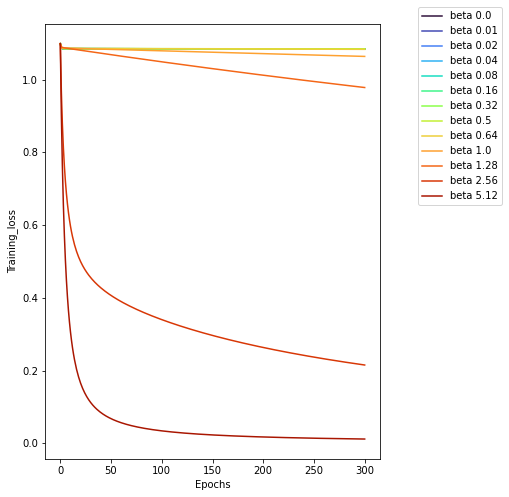

In [51]:
cm = plt.get_cmap('turbo')
fig = plt.figure(figsize=(6,8))
for i,j in enumerate(loss_beta):
    plt.plot(j,label ="beta "+str(np.around(beta[i].item(),3)),color = cm(i*20))

plt.xlabel("Epochs")
plt.ylabel("Training_loss")

plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.savefig("cin_train_loss_3.png",bbox_inches='tight')

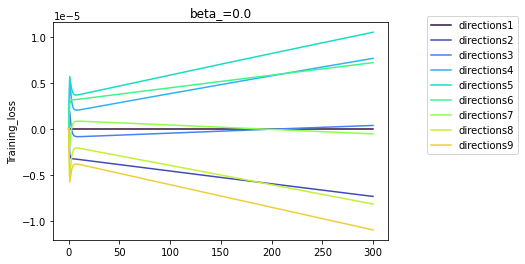

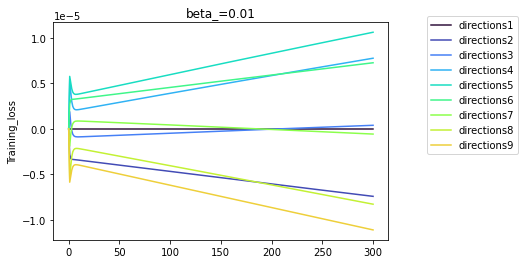

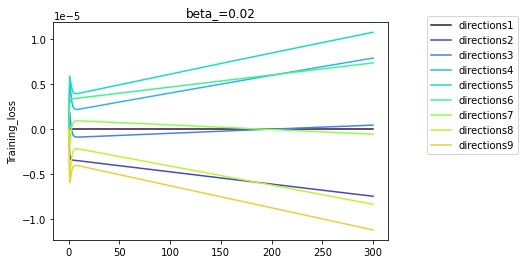

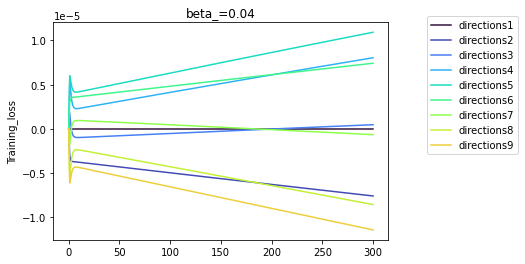

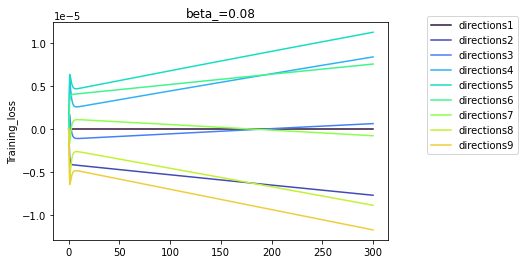

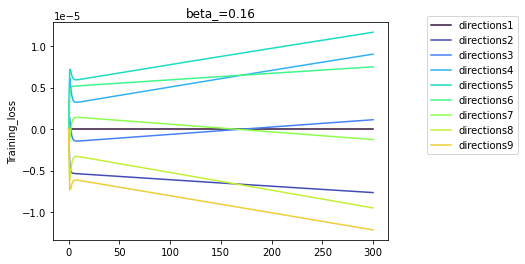

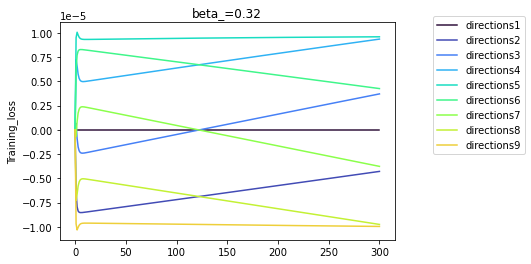

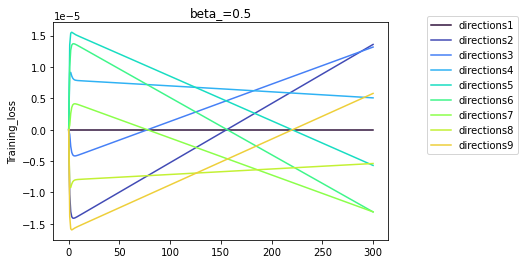

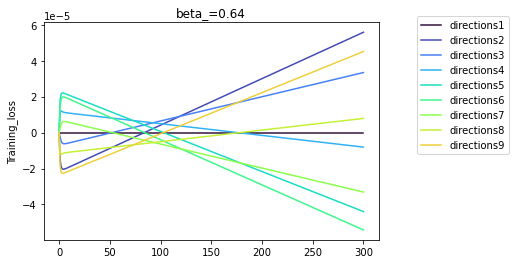

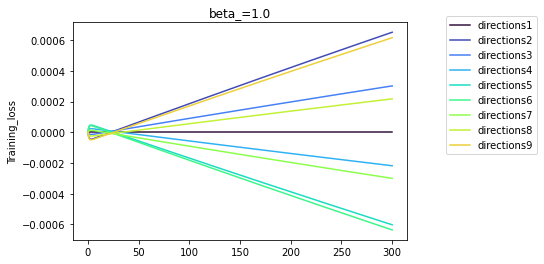

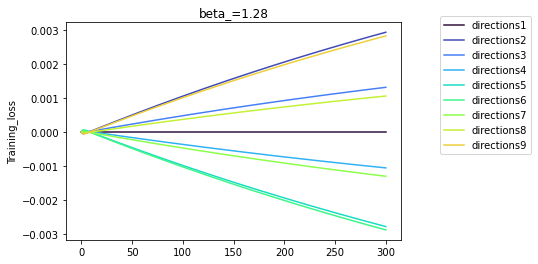

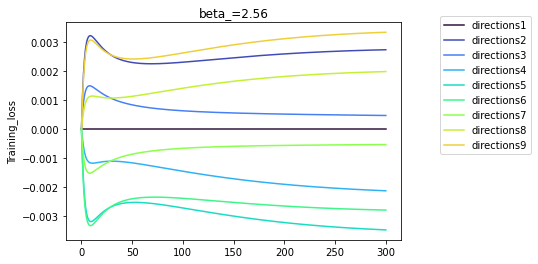

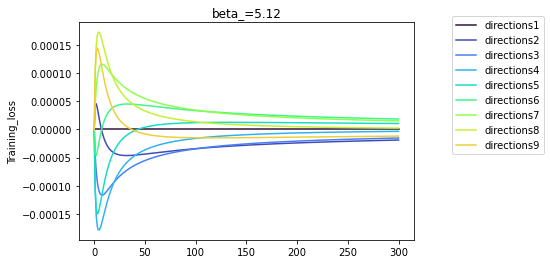

In [52]:
for j in range(len(beta)):
    plt.figure()
    for i in range(len(directions)+1):
        temp = np.array(loss_beta[j]) - test_loss_beta[j][:,i]
        plt.plot(temp,label ="directions"+str(i+1),color = cm(i*20))
        plt.ylabel("Training_loss")
        plt.legend(bbox_to_anchor=(1.1, 1.05))
        plt.title("beta_="+str(np.around(beta[j].item(),3)))
        plt.savefig("cin_train_loss_3_loss_beta_"+str(j)+".png",bbox_inches='tight')

In [53]:
# test_loss_beta

In [54]:
# test_loss_beta[0][:,1]

In [55]:
def hard_attention_generate_attended_data(trainloader,focus,focus_direction=None):
    mosaic_data = [] 
    attended_labels = []
    alpha_data = []
    
    for i, data in  enumerate(trainloader):
        inputs , labels , fore_idx = data
        batch = inputs.size(0)
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.double()
        if focus_direction is None:
            alpha, avg_data = focus(inputs)
        else:
            z = inputs
            batch = z.size(0)
            patches = z.size(1)
            dims = z.size(2)
            z = z.view(batch,patches,dims)
            alp1,ft1 = focus.helper(z)
            alp2,ft2 = focus_direction.helper(z)
            alp3 = alp1 + alp2
            alpha = F.softmax(alp3,dim=1)[:,:,0]
        mosaic_data.append(inputs)
        attended_labels.append(labels)
        alpha_data.append(alpha)
        
    mosaic_data = torch.cat(mosaic_data,dim=0)
    attended_labels = torch.cat(attended_labels,dim=0)
    alpha_data = torch.cat(alpha_data,dim=0)
    return mosaic_data,attended_labels,alpha_data

In [56]:
def hard_attention_calculate_loss(data,labels,alphas,net,criterion,train_mode=True):
    if train_mode:
        net.train()
        outputs = net(data)
        batch = outputs.size(0)
        patches = outputs.size(1)
        classes = outputs.size(2)
        
        outputs = torch.reshape(outputs,(batch*patches,classes))
        labels = labels.repeat_interleave(patches)
        loss = criterion(outputs,labels)
        loss = torch.reshape(loss,(batch,patches))
        loss = torch.mul(alphas,loss)
        loss = torch.sum(loss,dim=1)
        loss = torch.mean(loss)
        return loss
    else:  
        net.eval()
        with torch.no_grad():
            outputs = net(data)
            batch = outputs.size(0)
            patches = outputs.size(1)
            classes = outputs.size(2)
            outputs = torch.reshape(outputs,(batch*patches,classes))
            labels = labels.repeat_interleave(patches)
            loss = criterion(outputs,labels)
            loss = torch.reshape(loss,(batch,patches))
            loss = torch.mul(alphas,loss)
            loss = torch.sum(loss,dim=1)
            loss = torch.mean(loss)
            return loss.item()
        

In [57]:
def train_hard_attention_classification_model(mosaic_data,mosaic_labels,alphas,classify_model,
                               n_classes,test_list,learning_rate=0.01):
    nos_epochs = 300
    if n_classes > 2:
        criterion = nn.CrossEntropyLoss(reduction="none")
    else:
        criterion = nn.BCELoss(reduction="none")
    optimizer_classify = optim.SGD(classify_model.parameters(), lr=learning_rate)#,  momentum=0.09)
    loss_list=[]
    test_loss_list = []
    #print("ddd",attended_data,attended_labels)
    #print("sss",test_list[0])
    with torch.no_grad():
        test_loss_epoch  = [] 
        epoch_loss = []
        
        # for train data at epoch zero
        loss = hard_attention_calculate_loss(mosaic_data,mosaic_labels,
                                             alphas,classify_model,criterion,train_mode=False)
        
        epoch_loss.append(loss)
        # for test data at epoch zero
        test_loss_epoch  = [] 
        for data in test_list:
            test_mosaic_data,test_mosaic_labels,test_alphas = data
            #print(test_mosaic_data.shape,test_mosaic_labels.shape,test_alphas.shape)
            
            test_loss = hard_attention_calculate_loss(test_mosaic_data,test_mosaic_labels,
                                                      test_alphas,classify_model,criterion,train_mode=False)
            test_loss_epoch.append(test_loss)
        test_loss_list.append(test_loss_epoch)
    loss_list.append(np.mean(epoch_loss))
        
    
    
    for epoch in range(nos_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_loss = []
        test_loss_epoch  = [] 
        classify_model.train()
        # zero the parameter gradients
        optimizer_classify.zero_grad()
        #outputs = classify_model(mosaic_data)
        #print(outputs.shape)
        # predicted values
        if n_classes > 2:
            _,predicted= torch.max(outputs,dim=1)
        else:
            predicted = (outputs.data[:,0]>0.5).type(torch.int64)
        loss = hard_attention_calculate_loss(mosaic_data,mosaic_labels,
                                             alphas,classify_model,criterion,train_mode=True)
        loss.backward()
        optimizer_classify.step()
        loss_ = hard_attention_calculate_loss(mosaic_data,mosaic_labels,
                                              alphas,classify_model,criterion,train_mode=False)
        epoch_loss.append(loss_)
        print('[%d] loss: %.3f' %(epoch + 1, np.mean(epoch_loss)))
        loss_list.append(np.mean(epoch_loss))
        # loss for test list, At every epoch for every direction perform forward pass and calculate loss
        for data in test_list:
            test_mosaic_data,test_mosaic_labels,test_alphas = data
            test_loss = hard_attention_calculate_loss(test_mosaic_data,test_mosaic_labels,test_alphas,
                                       classify_model,criterion,train_mode=False)
            test_loss_epoch.append(test_loss)
        test_loss_list.append(test_loss_epoch)    
        if(np.mean(epoch_loss) <= 0.01):
            break    
    print('Finished Training')
    print(len(loss_list),len(test_loss_list))
    return classify_model,loss_list,test_loss_list

In [64]:
weight = torch.tensor([[1.49467446, -0.00920422]],dtype=torch.float64)
weight = weight/torch.linalg.norm(weight)
print(torch.linalg.norm(weight))
loss_beta = []
test_loss_beta = []
for beta_ in beta:
    focus_net = Focus(input_dims = 2,attention="hard").double()
    focus_net = focus_net.to(device)
    focus_net.fc1.weight.data = beta_*weight
    focus_net.fc1.weight.requires_grad = False
    

    
    classify = Classification(input_dims=2,output_dims=3).double()
    classify.apply(initialize_zeros_weights)
    classify = classify.to(device)
    

    
    print("Parameters")
    
    for params in focus_net.named_parameters():
        print(params)
    
    # attended data for focus model 
    f_mosaic_data,f_mosaic_labels,f_alphas =  hard_attention_generate_attended_data(train_loader,focus_net)
    
    
    # test attended data for focus model with 8 directions
    test_attended_data = []
    test_attended_data.append([f_mosaic_data,f_mosaic_labels,f_alphas])
    
    for u in directions:
        focus_net_direction = Focus(input_dims = 2,attention="hard").double()
        focus_net_direction = focus_net_direction.to(device)
        focus_net_direction.fc1.weight.data = 0.01*u[None,:]
        focus_net_direction.fc1.weight.requires_grad = False
        d_mosaic_data,d_mosaic_labels,d_alphas =  hard_attention_generate_attended_data(train_loader,
                                                                                        focus_net,
                                                                                        focus_net_direction)

        test_attended_data.append([d_mosaic_data,d_mosaic_labels,d_alphas ])

        
        
    
    _,loss_list,test_loss_list = train_hard_attention_classification_model(f_mosaic_data,f_mosaic_labels,
                                                                          f_alphas,classify,n_classes=3,
                                                                          test_list=test_attended_data,
                                                                          learning_rate=0.1)
    
    test_loss_list = np.array(test_loss_list)
    
    loss_beta.append(loss_list)
    test_loss_beta.append(test_loss_list)

tensor(1.0000, dtype=torch.float64)
Parameters
('fc1.weight', Parameter containing:
tensor([[0., -0.]], dtype=torch.float64))
[1] loss: 1.095
[2] loss: 1.093
[3] loss: 1.091
[4] loss: 1.090
[5] loss: 1.089
[6] loss: 1.088
[7] loss: 1.087
[8] loss: 1.087
[9] loss: 1.086
[10] loss: 1.086
[11] loss: 1.086
[12] loss: 1.086
[13] loss: 1.086
[14] loss: 1.085
[15] loss: 1.085
[16] loss: 1.085
[17] loss: 1.085
[18] loss: 1.085
[19] loss: 1.085
[20] loss: 1.085
[21] loss: 1.085
[22] loss: 1.085
[23] loss: 1.085
[24] loss: 1.085
[25] loss: 1.085
[26] loss: 1.085
[27] loss: 1.085
[28] loss: 1.085
[29] loss: 1.085
[30] loss: 1.085
[31] loss: 1.085
[32] loss: 1.085
[33] loss: 1.085
[34] loss: 1.085
[35] loss: 1.085
[36] loss: 1.085
[37] loss: 1.085
[38] loss: 1.085
[39] loss: 1.085
[40] loss: 1.085
[41] loss: 1.085
[42] loss: 1.085
[43] loss: 1.085
[44] loss: 1.085
[45] loss: 1.085
[46] loss: 1.085
[47] loss: 1.085
[48] loss: 1.085
[49] loss: 1.085
[50] loss: 1.085
[51] loss: 1.085
[52] loss: 1.085

[154] loss: 1.085
[155] loss: 1.085
[156] loss: 1.085
[157] loss: 1.085
[158] loss: 1.085
[159] loss: 1.085
[160] loss: 1.085
[161] loss: 1.085
[162] loss: 1.085
[163] loss: 1.085
[164] loss: 1.085
[165] loss: 1.085
[166] loss: 1.085
[167] loss: 1.085
[168] loss: 1.085
[169] loss: 1.085
[170] loss: 1.085
[171] loss: 1.085
[172] loss: 1.085
[173] loss: 1.085
[174] loss: 1.085
[175] loss: 1.085
[176] loss: 1.085
[177] loss: 1.085
[178] loss: 1.085
[179] loss: 1.085
[180] loss: 1.085
[181] loss: 1.085
[182] loss: 1.085
[183] loss: 1.085
[184] loss: 1.085
[185] loss: 1.085
[186] loss: 1.085
[187] loss: 1.085
[188] loss: 1.085
[189] loss: 1.085
[190] loss: 1.085
[191] loss: 1.085
[192] loss: 1.085
[193] loss: 1.085
[194] loss: 1.085
[195] loss: 1.085
[196] loss: 1.085
[197] loss: 1.085
[198] loss: 1.085
[199] loss: 1.085
[200] loss: 1.085
[201] loss: 1.085
[202] loss: 1.085
[203] loss: 1.085
[204] loss: 1.085
[205] loss: 1.085
[206] loss: 1.085
[207] loss: 1.085
[208] loss: 1.085
[209] loss

[2] loss: 1.093
[3] loss: 1.091
[4] loss: 1.090
[5] loss: 1.089
[6] loss: 1.088
[7] loss: 1.087
[8] loss: 1.087
[9] loss: 1.086
[10] loss: 1.086
[11] loss: 1.086
[12] loss: 1.086
[13] loss: 1.086
[14] loss: 1.085
[15] loss: 1.085
[16] loss: 1.085
[17] loss: 1.085
[18] loss: 1.085
[19] loss: 1.085
[20] loss: 1.085
[21] loss: 1.085
[22] loss: 1.085
[23] loss: 1.085
[24] loss: 1.085
[25] loss: 1.085
[26] loss: 1.085
[27] loss: 1.085
[28] loss: 1.085
[29] loss: 1.085
[30] loss: 1.085
[31] loss: 1.085
[32] loss: 1.085
[33] loss: 1.085
[34] loss: 1.085
[35] loss: 1.085
[36] loss: 1.085
[37] loss: 1.085
[38] loss: 1.085
[39] loss: 1.085
[40] loss: 1.085
[41] loss: 1.085
[42] loss: 1.085
[43] loss: 1.085
[44] loss: 1.085
[45] loss: 1.085
[46] loss: 1.085
[47] loss: 1.085
[48] loss: 1.085
[49] loss: 1.085
[50] loss: 1.085
[51] loss: 1.085
[52] loss: 1.085
[53] loss: 1.085
[54] loss: 1.085
[55] loss: 1.085
[56] loss: 1.085
[57] loss: 1.085
[58] loss: 1.085
[59] loss: 1.085
[60] loss: 1.085
[61] 

[164] loss: 1.085
[165] loss: 1.085
[166] loss: 1.085
[167] loss: 1.085
[168] loss: 1.085
[169] loss: 1.085
[170] loss: 1.085
[171] loss: 1.085
[172] loss: 1.085
[173] loss: 1.085
[174] loss: 1.085
[175] loss: 1.085
[176] loss: 1.085
[177] loss: 1.085
[178] loss: 1.085
[179] loss: 1.085
[180] loss: 1.085
[181] loss: 1.085
[182] loss: 1.085
[183] loss: 1.085
[184] loss: 1.085
[185] loss: 1.085
[186] loss: 1.085
[187] loss: 1.085
[188] loss: 1.085
[189] loss: 1.085
[190] loss: 1.085
[191] loss: 1.085
[192] loss: 1.085
[193] loss: 1.085
[194] loss: 1.085
[195] loss: 1.085
[196] loss: 1.085
[197] loss: 1.085
[198] loss: 1.085
[199] loss: 1.085
[200] loss: 1.085
[201] loss: 1.085
[202] loss: 1.085
[203] loss: 1.085
[204] loss: 1.085
[205] loss: 1.085
[206] loss: 1.085
[207] loss: 1.085
[208] loss: 1.085
[209] loss: 1.085
[210] loss: 1.085
[211] loss: 1.085
[212] loss: 1.085
[213] loss: 1.085
[214] loss: 1.085
[215] loss: 1.085
[216] loss: 1.085
[217] loss: 1.085
[218] loss: 1.085
[219] loss

[16] loss: 1.086
[17] loss: 1.085
[18] loss: 1.085
[19] loss: 1.085
[20] loss: 1.085
[21] loss: 1.085
[22] loss: 1.085
[23] loss: 1.085
[24] loss: 1.085
[25] loss: 1.085
[26] loss: 1.085
[27] loss: 1.085
[28] loss: 1.085
[29] loss: 1.085
[30] loss: 1.085
[31] loss: 1.085
[32] loss: 1.085
[33] loss: 1.085
[34] loss: 1.085
[35] loss: 1.085
[36] loss: 1.085
[37] loss: 1.085
[38] loss: 1.085
[39] loss: 1.085
[40] loss: 1.085
[41] loss: 1.085
[42] loss: 1.085
[43] loss: 1.085
[44] loss: 1.085
[45] loss: 1.085
[46] loss: 1.085
[47] loss: 1.085
[48] loss: 1.085
[49] loss: 1.085
[50] loss: 1.085
[51] loss: 1.085
[52] loss: 1.085
[53] loss: 1.085
[54] loss: 1.085
[55] loss: 1.085
[56] loss: 1.085
[57] loss: 1.085
[58] loss: 1.085
[59] loss: 1.085
[60] loss: 1.085
[61] loss: 1.085
[62] loss: 1.085
[63] loss: 1.085
[64] loss: 1.085
[65] loss: 1.085
[66] loss: 1.085
[67] loss: 1.085
[68] loss: 1.085
[69] loss: 1.085
[70] loss: 1.085
[71] loss: 1.085
[72] loss: 1.085
[73] loss: 1.085
[74] loss: 1.0

[178] loss: 1.085
[179] loss: 1.085
[180] loss: 1.085
[181] loss: 1.085
[182] loss: 1.085
[183] loss: 1.085
[184] loss: 1.085
[185] loss: 1.085
[186] loss: 1.085
[187] loss: 1.085
[188] loss: 1.085
[189] loss: 1.085
[190] loss: 1.085
[191] loss: 1.085
[192] loss: 1.085
[193] loss: 1.085
[194] loss: 1.085
[195] loss: 1.085
[196] loss: 1.085
[197] loss: 1.085
[198] loss: 1.085
[199] loss: 1.085
[200] loss: 1.085
[201] loss: 1.085
[202] loss: 1.085
[203] loss: 1.085
[204] loss: 1.085
[205] loss: 1.085
[206] loss: 1.085
[207] loss: 1.085
[208] loss: 1.085
[209] loss: 1.085
[210] loss: 1.085
[211] loss: 1.085
[212] loss: 1.085
[213] loss: 1.085
[214] loss: 1.085
[215] loss: 1.085
[216] loss: 1.085
[217] loss: 1.085
[218] loss: 1.085
[219] loss: 1.085
[220] loss: 1.085
[221] loss: 1.085
[222] loss: 1.085
[223] loss: 1.085
[224] loss: 1.085
[225] loss: 1.085
[226] loss: 1.085
[227] loss: 1.085
[228] loss: 1.085
[229] loss: 1.085
[230] loss: 1.085
[231] loss: 1.085
[232] loss: 1.085
[233] loss

[31] loss: 1.087
[32] loss: 1.087
[33] loss: 1.087
[34] loss: 1.086
[35] loss: 1.086
[36] loss: 1.086
[37] loss: 1.086
[38] loss: 1.086
[39] loss: 1.086
[40] loss: 1.086
[41] loss: 1.086
[42] loss: 1.086
[43] loss: 1.086
[44] loss: 1.086
[45] loss: 1.086
[46] loss: 1.086
[47] loss: 1.086
[48] loss: 1.086
[49] loss: 1.086
[50] loss: 1.086
[51] loss: 1.086
[52] loss: 1.086
[53] loss: 1.086
[54] loss: 1.086
[55] loss: 1.086
[56] loss: 1.086
[57] loss: 1.086
[58] loss: 1.086
[59] loss: 1.086
[60] loss: 1.086
[61] loss: 1.086
[62] loss: 1.086
[63] loss: 1.086
[64] loss: 1.086
[65] loss: 1.086
[66] loss: 1.086
[67] loss: 1.086
[68] loss: 1.086
[69] loss: 1.086
[70] loss: 1.086
[71] loss: 1.086
[72] loss: 1.086
[73] loss: 1.086
[74] loss: 1.086
[75] loss: 1.086
[76] loss: 1.086
[77] loss: 1.086
[78] loss: 1.086
[79] loss: 1.086
[80] loss: 1.086
[81] loss: 1.086
[82] loss: 1.086
[83] loss: 1.086
[84] loss: 1.086
[85] loss: 1.085
[86] loss: 1.085
[87] loss: 1.085
[88] loss: 1.085
[89] loss: 1.0

[190] loss: 1.077
[191] loss: 1.077
[192] loss: 1.077
[193] loss: 1.077
[194] loss: 1.077
[195] loss: 1.077
[196] loss: 1.077
[197] loss: 1.077
[198] loss: 1.077
[199] loss: 1.077
[200] loss: 1.077
[201] loss: 1.077
[202] loss: 1.077
[203] loss: 1.077
[204] loss: 1.077
[205] loss: 1.077
[206] loss: 1.077
[207] loss: 1.077
[208] loss: 1.077
[209] loss: 1.077
[210] loss: 1.077
[211] loss: 1.077
[212] loss: 1.077
[213] loss: 1.077
[214] loss: 1.077
[215] loss: 1.077
[216] loss: 1.077
[217] loss: 1.077
[218] loss: 1.077
[219] loss: 1.076
[220] loss: 1.076
[221] loss: 1.076
[222] loss: 1.076
[223] loss: 1.076
[224] loss: 1.076
[225] loss: 1.076
[226] loss: 1.076
[227] loss: 1.076
[228] loss: 1.076
[229] loss: 1.076
[230] loss: 1.076
[231] loss: 1.076
[232] loss: 1.076
[233] loss: 1.076
[234] loss: 1.076
[235] loss: 1.076
[236] loss: 1.076
[237] loss: 1.076
[238] loss: 1.076
[239] loss: 1.076
[240] loss: 1.076
[241] loss: 1.076
[242] loss: 1.076
[243] loss: 1.076
[244] loss: 1.076
[245] loss

[43] loss: 0.432
[44] loss: 0.427
[45] loss: 0.421
[46] loss: 0.416
[47] loss: 0.412
[48] loss: 0.407
[49] loss: 0.402
[50] loss: 0.398
[51] loss: 0.394
[52] loss: 0.389
[53] loss: 0.385
[54] loss: 0.381
[55] loss: 0.378
[56] loss: 0.374
[57] loss: 0.370
[58] loss: 0.367
[59] loss: 0.363
[60] loss: 0.360
[61] loss: 0.357
[62] loss: 0.353
[63] loss: 0.350
[64] loss: 0.347
[65] loss: 0.344
[66] loss: 0.341
[67] loss: 0.339
[68] loss: 0.336
[69] loss: 0.333
[70] loss: 0.331
[71] loss: 0.328
[72] loss: 0.325
[73] loss: 0.323
[74] loss: 0.321
[75] loss: 0.318
[76] loss: 0.316
[77] loss: 0.314
[78] loss: 0.311
[79] loss: 0.309
[80] loss: 0.307
[81] loss: 0.305
[82] loss: 0.303
[83] loss: 0.301
[84] loss: 0.299
[85] loss: 0.297
[86] loss: 0.295
[87] loss: 0.293
[88] loss: 0.292
[89] loss: 0.290
[90] loss: 0.288
[91] loss: 0.286
[92] loss: 0.285
[93] loss: 0.283
[94] loss: 0.281
[95] loss: 0.280
[96] loss: 0.278
[97] loss: 0.277
[98] loss: 0.275
[99] loss: 0.274
[100] loss: 0.272
[101] loss: 0

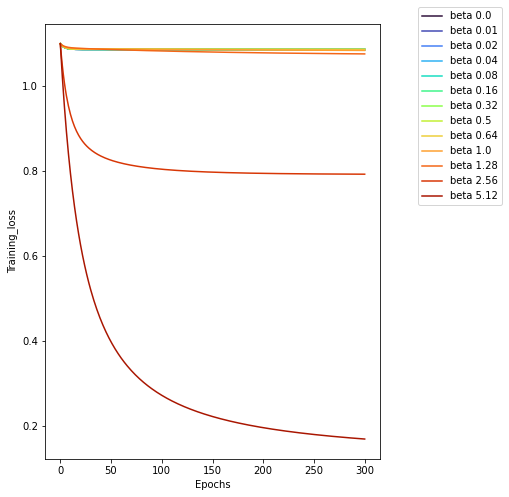

In [65]:
cm = plt.get_cmap('turbo')
fig = plt.figure(figsize=(6,8))
for i,j in enumerate(loss_beta):
    plt.plot(j,label ="beta "+str(np.around(beta[i].item(),3)),color = cm(i*20))

plt.xlabel("Epochs")
plt.ylabel("Training_loss")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.savefig("sin_train_loss_3.png",bbox_inches='tight')

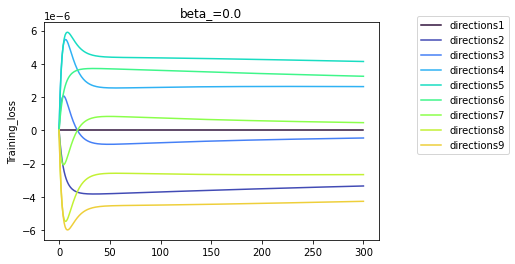

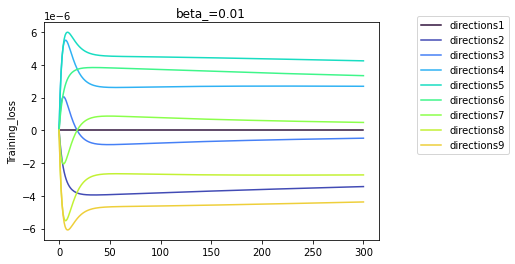

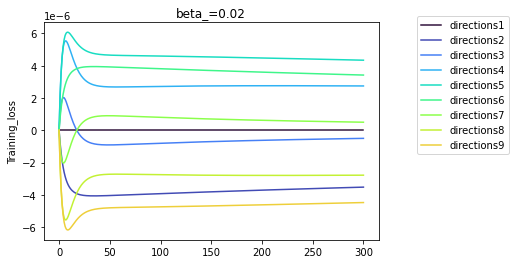

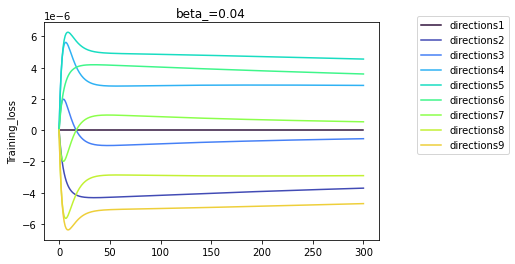

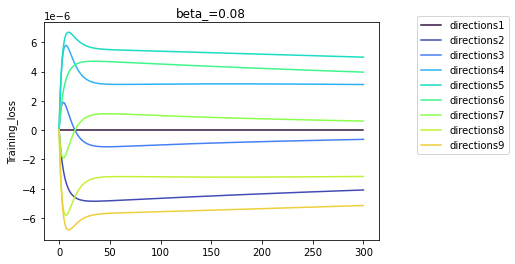

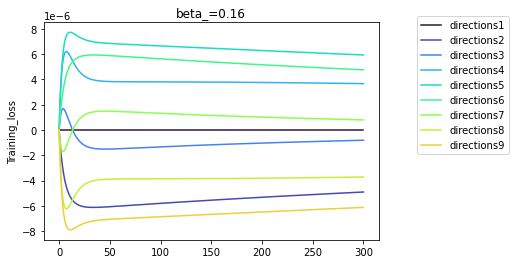

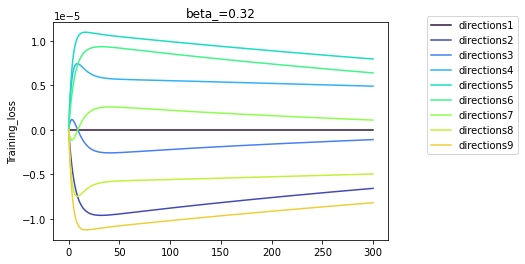

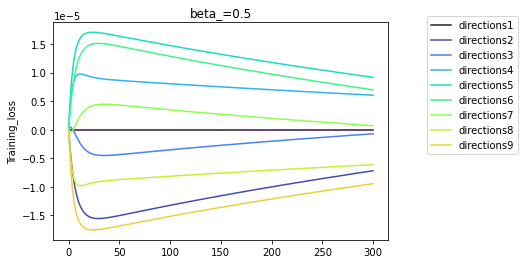

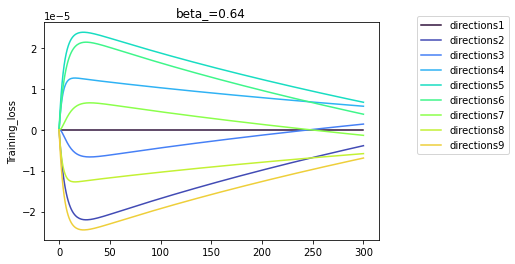

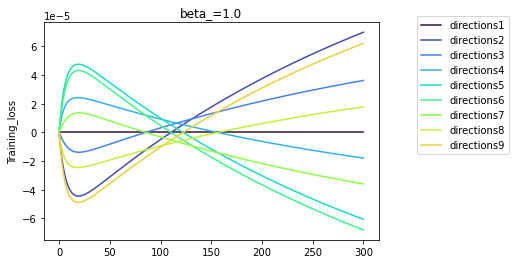

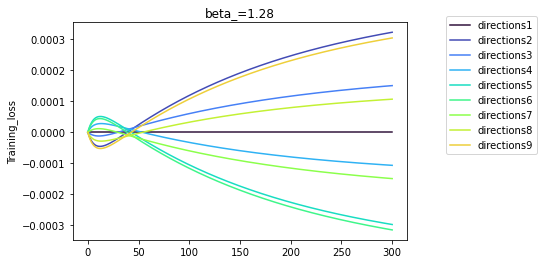

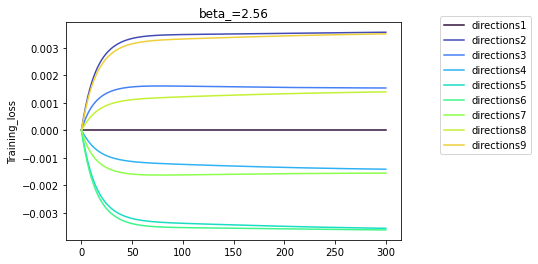

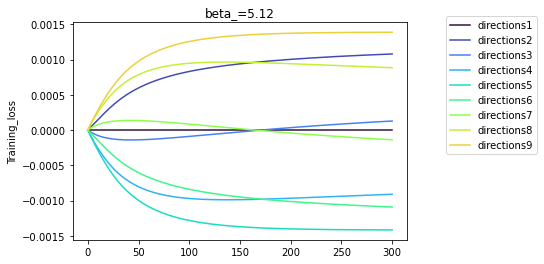

In [66]:
for j in range(len(beta)):
    plt.figure()
    for i in range(len(directions)+1):
        temp = np.array(loss_beta[j]) - test_loss_beta[j][:,i]
        plt.plot(temp,label ="directions"+str(i+1),color = cm(i*20))
        plt.ylabel("Training_loss")
        plt.legend(bbox_to_anchor=(1.1, 1.05))
        plt.title("beta_="+str(np.around(beta[j].item(),3)))
        plt.savefig("sin_train_loss_3_loss_beta_"+str(j)+".png",bbox_inches='tight')